In [1]:
pip install pytorch_spiking

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import time
import pytorch_spiking

torch.manual_seed(0)
np.random.seed(0)

4422102/4422102 [==============================] - 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


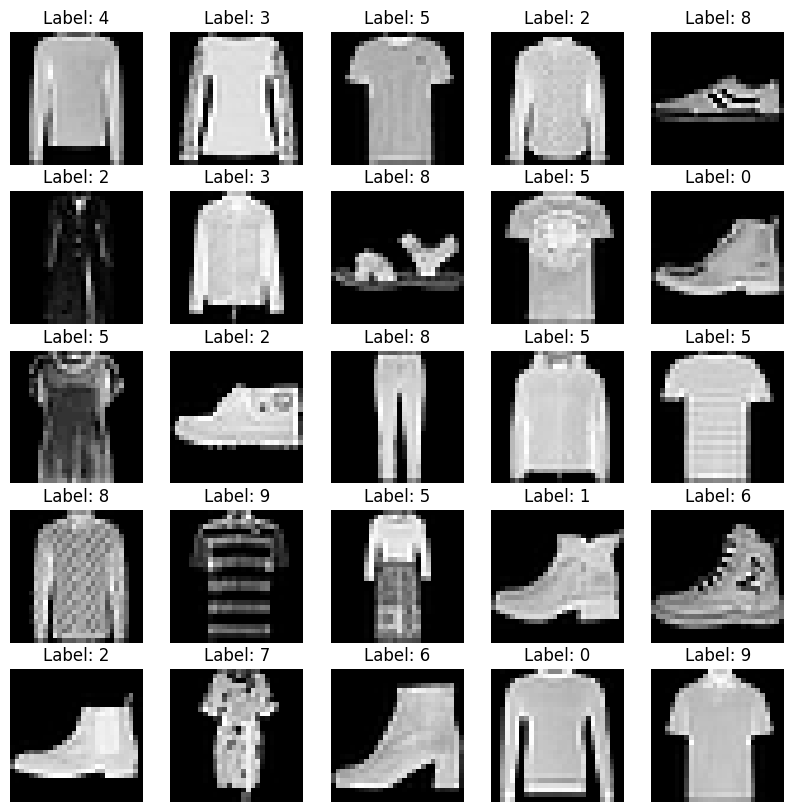

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


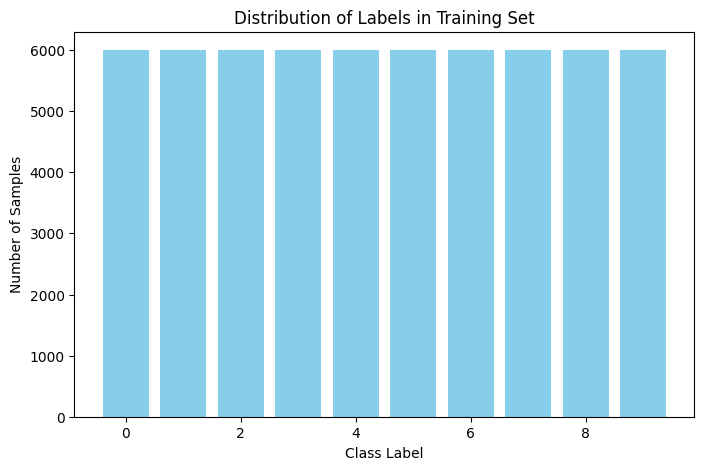

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load the FashionMNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Explore the dataset
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

# Display a random sample of images with their corresponding labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0])], cmap='gray')
    plt.title(f"Label: {y_train[np.random.randint(0, y_train.shape[0])]}")
    plt.axis('off')
plt.show()

# Check unique labels in the dataset
unique_labels = np.unique(y_train)
print("Unique labels:", unique_labels)

# Display the count of each class in the training set
label_counts = np.bincount(y_train)
for label, count in enumerate(label_counts):
    print(f"Class {label}: {count} samples")

# Display the distribution of labels in the training set
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, label_counts[unique_labels], color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Training Set')
plt.show()


100%|██████████| 26421880/26421880 [00:01<00:00, 15656554.31it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272213.07it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5063932.46it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15703474.18it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



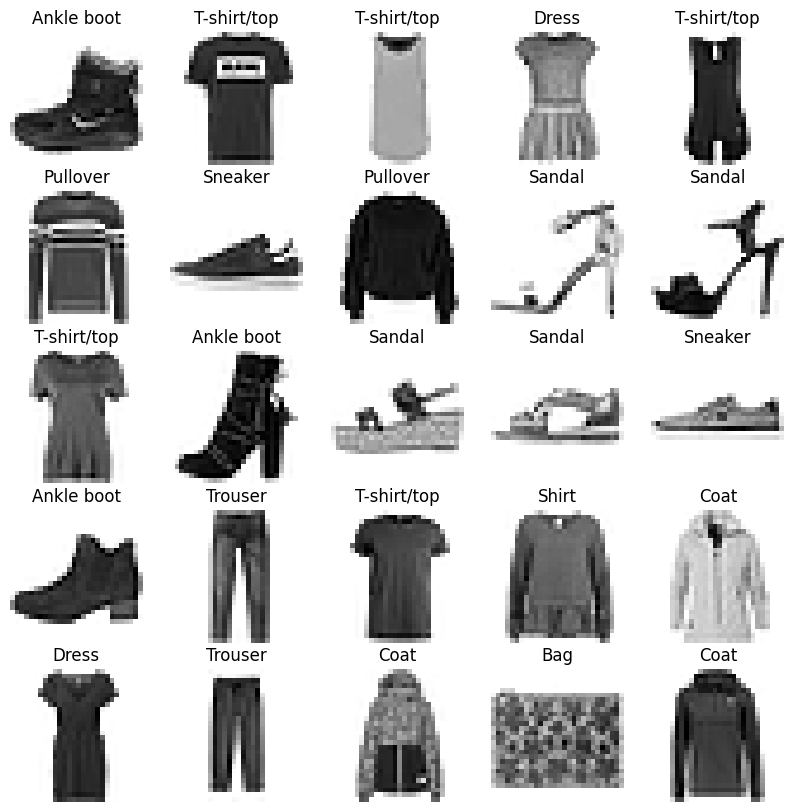

In [3]:
train_pictures, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_pictures = np.asarray([np.array(pic) for pic in train_pictures], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
test_pictures, test_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=False, download=True)
)
test_pictures = np.asarray([np.array(pic) for pic in train_pictures], dtype=np.float32)
test_labels = np.asarray(train_labels, dtype=np.int64)

# normalize images so values are between 0 and 1
train_pictures = train_pictures / 255.0
test_pictures = test_pictures / 255.0

class_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_labels)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_pictures[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_labels[train_labels[i]])

In [9]:
def train(input_ssn, train_x, test_x):
    minibatch_size = 16
    optimizer = torch.optim.Adam(input_ssn.parameters())
    s = time.time()
    input_ssn.train()

    # Initialize variables for early stopping
    patience = 5
    best_loss = float('inf')
    best_epoch = 0
    early_stop = False

    for j in range(100):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_ssn.zero_grad()

            input_batch = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            input_batch = input_batch.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_ssn(torch.tensor(input_batch))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()

            loss.backward()#bptt
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print(f"Accuracy(Training) ({j}): {train_acc.numpy()}")

        # Check if the loss has improved for early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = j
        elif j - best_epoch > patience:
            print("Early stopping due to no improvement in loss.")
            early_stop = True
            break

    train_time= time.time() - s
    print("Training time:",train_time)


        # compute test accuracy
    s1=time.time()
    input_ssn.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
            input_batch = test_x[i * minibatch_size : (i + 1) * minibatch_size]
            input_batch = input_batch.reshape((-1,) + test_x.shape[1:-2] + (784,))
            batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_ssn(torch.tensor(input_batch))

            test_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

    test_acc /= i + 1

    print(f"Accuracy(Testing) {test_acc.numpy()}")
    e=time.time()-s

# train the model, identically to the non-spiking version,
# except using the time sequences as input


In [10]:
# repeat the images for n_steps
n_steps = 10
train_stream = np.tile(train_pictures[:, None], (1, n_steps, 1, 1))
test_stream = np.tile(test_pictures[:, None], (1, n_steps, 1, 1))

In [ ]:
spiking_model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=False),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=False),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 10),
)


# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8009333610534668
Accuracy(Training) (1): 0.8584166765213013
Accuracy(Training) (2): 0.8722666501998901
Accuracy(Training) (3): 0.8814166784286499
Accuracy(Training) (4): 0.8876500129699707
Accuracy(Training) (5): 0.8929166793823242
Accuracy(Training) (6): 0.8974666595458984
Accuracy(Training) (7): 0.9005166888237
Accuracy(Training) (8): 0.903333306312561
Accuracy(Training) (9): 0.9065999984741211
Training time: 227.3446764945984
Accuracy(Testing) 0.16519999504089355
Testing/Simulation time 236.5902464389801


In [ ]:
spiking_modelx= torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=True),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=False),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 10),
)


# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_modelx, train_stream, test_stream)

Accuracy(Training) (0): 0.4632500112056732
Accuracy(Training) (1): 0.6221666932106018
Accuracy(Training) (2): 0.6657333374023438
Accuracy(Training) (3): 0.6888833045959473
Accuracy(Training) (4): 0.7042499780654907
Accuracy(Training) (5): 0.7165166735649109
Accuracy(Training) (6): 0.7277166843414307
Accuracy(Training) (7): 0.7382333278656006
Accuracy(Training) (8): 0.7367666959762573
Accuracy(Training) (9): 0.7446666955947876
Training time: 234.80650568008423
Accuracy(Testing) 0.7457166910171509
Testing/Simulation time 244.4990165233612


In [6]:
class SelfAttention(torch.nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = torch.nn.Linear(input_dim, input_dim)
        self.key = torch.nn.Linear(input_dim, input_dim)
        self.value = torch.nn.Linear(input_dim, input_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_weights = torch.nn.functional.softmax(q @ k.transpose(-2, -1), dim=-1)
        return attn_weights @ v

In [13]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.SiLU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
     SelfAttention(64),
     torch.nn.Dropout(0.5),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.777400016784668
Accuracy(Training) (1): 0.7138166427612305
Accuracy(Training) (2): 0.7437000274658203
Accuracy(Training) (3): 0.7164666652679443
Accuracy(Training) (4): 0.723966658115387
Accuracy(Training) (5): 0.708133339881897
Accuracy(Training) (6): 0.7204166650772095
Accuracy(Training) (7): 0.6545166373252869
Accuracy(Training) (8): 0.6994666457176208
Accuracy(Training) (9): 0.6460999846458435
Accuracy(Training) (10): 0.15129999816417694
Accuracy(Training) (11): 0.10221666842699051
Early stopping due to no improvement in loss.
Training time: 1235.2450091838837
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.5),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8090166449546814
Accuracy(Training) (1): 0.8511333465576172
Accuracy(Training) (2): 0.8641666769981384
Accuracy(Training) (3): 0.8714333176612854
Accuracy(Training) (4): 0.8775166869163513
Accuracy(Training) (5): 0.8834499716758728
Accuracy(Training) (6): 0.8860999941825867
Accuracy(Training) (7): 0.8915166854858398
Accuracy(Training) (8): 0.8955333232879639
Accuracy(Training) (9): 0.8981500267982483
Accuracy(Training) (10): 0.8996166586875916
Accuracy(Training) (11): 0.9033666849136353
Accuracy(Training) (12): 0.904699981212616
Accuracy(Training) (13): 0.7803000211715698
Accuracy(Training) (14): 0.5879666805267334
Accuracy(Training) (15): 0.6084333062171936
Early stopping due to no improvement in loss.
Training time: 1208.07932305336
Accuracy(Testing) 0.17991666495800018


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8080999851226807
Accuracy(Training) (1): 0.8496000170707703
Accuracy(Training) (2): 0.8618333339691162
Accuracy(Training) (3): 0.8712999820709229
Accuracy(Training) (4): 0.8794000148773193
Accuracy(Training) (5): 0.8852666616439819
Accuracy(Training) (6): 0.8903166651725769
Accuracy(Training) (7): 0.8941666483879089
Accuracy(Training) (8): 0.8983166813850403
Accuracy(Training) (9): 0.9018499851226807
Accuracy(Training) (10): 0.904283344745636
Accuracy(Training) (11): 0.9075999855995178
Accuracy(Training) (12): 0.9115999937057495
Accuracy(Training) (13): 0.9137833118438721
Accuracy(Training) (14): 0.9150333404541016
Accuracy(Training) (15): 0.8155666589736938
Accuracy(Training) (16): 0.5946666598320007
Accuracy(Training) (17): 0.6810333132743835
Accuracy(Training) (18): 0.6378166675567627
Early stopping due to no improvement in loss.
Training time: 1381.9913308620453
Accuracy(Testing) 0.6440833210945129


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.3),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8060166835784912
Accuracy(Training) (1): 0.8486999869346619
Accuracy(Training) (2): 0.8630333542823792
Accuracy(Training) (3): 0.8717666864395142
Accuracy(Training) (4): 0.8787166476249695
Accuracy(Training) (5): 0.8834499716758728
Accuracy(Training) (6): 0.8900666832923889
Accuracy(Training) (7): 0.8942000269889832
Accuracy(Training) (8): 0.8966000080108643
Accuracy(Training) (9): 0.8999000191688538
Accuracy(Training) (10): 0.9025999903678894
Accuracy(Training) (11): 0.9052666425704956
Accuracy(Training) (12): 0.9087499976158142
Accuracy(Training) (13): 0.9115999937057495
Accuracy(Training) (14): 0.9127833247184753
Accuracy(Training) (15): 0.9130333065986633
Accuracy(Training) (16): 0.6804333329200745
Accuracy(Training) (17): 0.6486833095550537
Accuracy(Training) (18): 0.656000018119812
Accuracy(Training) (19): 0.6253499984741211
Early stopping due to no improvement in loss.
Training time: 1508.8464205265045
Accuracy(Testing) 0.5193166732788086


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8051166534423828
Accuracy(Training) (1): 0.8504666686058044
Accuracy(Training) (2): 0.8637666702270508
Accuracy(Training) (3): 0.8721666932106018
Accuracy(Training) (4): 0.8783666491508484
Accuracy(Training) (5): 0.883566677570343
Accuracy(Training) (6): 0.8883333206176758
Accuracy(Training) (7): 0.8931833505630493
Accuracy(Training) (8): 0.8987500071525574
Accuracy(Training) (9): 0.9010000228881836
Accuracy(Training) (10): 0.9049666523933411
Accuracy(Training) (11): 0.90829998254776
Accuracy(Training) (12): 0.9120166897773743
Accuracy(Training) (13): 0.912933349609375
Accuracy(Training) (14): 0.9159500002861023
Accuracy(Training) (15): 0.9172833561897278
Accuracy(Training) (16): 0.9195666909217834
Accuracy(Training) (17): 0.9228166937828064
Accuracy(Training) (18): 0.9228666424751282
Accuracy(Training) (19): 0.6107000112533569
Accuracy(Training) (20): 0.5866166949272156
Accuracy(Training) (21): 0.6449999809265137
Accuracy(Training) (22): 0.6359833478927612
Ac

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.7),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8067833185195923
Accuracy(Training) (1): 0.847000002861023
Accuracy(Training) (2): 0.8589333295822144
Accuracy(Training) (3): 0.8684499859809875
Accuracy(Training) (4): 0.8728333115577698
Accuracy(Training) (5): 0.8780166506767273
Accuracy(Training) (6): 0.8811833262443542
Accuracy(Training) (7): 0.8859500288963318
Accuracy(Training) (8): 0.888700008392334
Accuracy(Training) (9): 0.8899000287055969
Accuracy(Training) (10): 0.5152833461761475
Accuracy(Training) (11): 0.2642500102519989
Accuracy(Training) (12): 0.1920499950647354
Accuracy(Training) (13): 0.10081666707992554
Accuracy(Training) (14): 0.09870000183582306
Accuracy(Training) (15): 0.10000000149011612
Early stopping due to no improvement in loss.
Training time: 1243.3944516181946
Accuracy(Testing) 0.10071666538715363


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=0.9), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8070999979972839
Accuracy(Training) (1): 0.8501666784286499
Accuracy(Training) (2): 0.863183319568634
Accuracy(Training) (3): 0.8713499903678894
Accuracy(Training) (4): 0.8792833089828491
Accuracy(Training) (5): 0.8849833607673645
Accuracy(Training) (6): 0.8898833394050598
Accuracy(Training) (7): 0.8942499756813049
Accuracy(Training) (8): 0.8987166881561279
Accuracy(Training) (9): 0.9033833146095276
Accuracy(Training) (10): 0.9057833552360535
Accuracy(Training) (11): 0.9084333181381226
Accuracy(Training) (12): 0.9123833179473877
Accuracy(Training) (13): 0.9145166873931885
Accuracy(Training) (14): 0.9162499904632568
Accuracy(Training) (15): 0.9189333319664001
Accuracy(Training) (16): 0.9190499782562256
Accuracy(Training) (17): 0.7093166708946228
Accuracy(Training) (18): 0.6783999800682068
Early stopping due to no improvement in loss.
Training time: 1456.6666750907898
Accuracy(Testing) 0.6048499941825867


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.7, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8085833191871643
Accuracy(Training) (1): 0.850600004196167
Accuracy(Training) (2): 0.8627333045005798
Accuracy(Training) (3): 0.8725166916847229
Accuracy(Training) (4): 0.8795833587646484
Accuracy(Training) (5): 0.885616660118103
Accuracy(Training) (6): 0.890250027179718
Accuracy(Training) (7): 0.8948833346366882
Accuracy(Training) (8): 0.8981833457946777
Accuracy(Training) (9): 0.9022166728973389
Accuracy(Training) (10): 0.904783308506012
Accuracy(Training) (11): 0.9078999757766724
Accuracy(Training) (12): 0.9116666913032532
Accuracy(Training) (13): 0.9119833111763
Accuracy(Training) (14): 0.9160500168800354
Accuracy(Training) (15): 0.7577166557312012
Accuracy(Training) (16): 0.6685166954994202
Accuracy(Training) (17): 0.6898833513259888
Accuracy(Training) (18): 0.6900333166122437
Accuracy(Training) (19): 0.6892833113670349
Accuracy(Training) (20): 0.6932833194732666
Early stopping due to no improvement in loss.
Training time: 1586.7588033676147
Accuracy(Test

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 512),
     SelfAttention(512),
     torch.nn.Dropout(0.5),
     torch.nn.Linear(512,256),
     torch.nn.ELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),

    torch.nn.Linear(256,64),
    torch.nn.SiLU(),


    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8009166717529297
Accuracy(Training) (1): 0.8373833298683167
Accuracy(Training) (2): 0.8486499786376953
Accuracy(Training) (3): 0.819350004196167
Accuracy(Training) (4): 0.09860000014305115
Accuracy(Training) (5): 0.09826666861772537
Accuracy(Training) (6): 0.09823333472013474
Accuracy(Training) (7): 0.09808333218097687
Accuracy(Training) (8): 0.09808333218097687
Early stopping due to no improvement in loss.
Training time: 1280.5960772037506
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),

    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7938500046730042
Accuracy(Training) (1): 0.8364499807357788
Accuracy(Training) (2): 0.8460999727249146
Accuracy(Training) (3): 0.856416642665863
Accuracy(Training) (4): 0.8597666621208191
Accuracy(Training) (5): 0.8670833110809326
Accuracy(Training) (6): 0.8691999912261963
Accuracy(Training) (7): 0.8718500137329102
Accuracy(Training) (8): 0.874916672706604
Accuracy(Training) (9): 0.8767666816711426
Accuracy(Training) (10): 0.8810666799545288
Accuracy(Training) (11): 0.8830333352088928
Accuracy(Training) (12): 0.8827000260353088
Accuracy(Training) (13): 0.8859666585922241
Accuracy(Training) (14): 0.8859333395957947
Accuracy(Training) (15): 0.8910333514213562
Accuracy(Training) (16): 0.8926166892051697
Accuracy(Training) (17): 0.8939666748046875
Accuracy(Training) (18): 0.8942833542823792
Accuracy(Training) (19): 0.8974000215530396
Accuracy(Training) (20): 0.8985166549682617
Early stopping due to no improvement in loss.
Training time: 744.1425306797028
Accuracy(

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.ELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.6759833097457886
Accuracy(Training) (1): 0.7900166511535645
Accuracy(Training) (2): 0.8172833323478699
Accuracy(Training) (3): 0.8330000042915344
Accuracy(Training) (4): 0.841616690158844
Accuracy(Training) (5): 0.8497999906539917
Accuracy(Training) (6): 0.8563500046730042
Accuracy(Training) (7): 0.8614833354949951
Accuracy(Training) (8): 0.8640999794006348
Accuracy(Training) (9): 0.8300333619117737
Accuracy(Training) (10): 0.7867000102996826
Accuracy(Training) (11): 0.7803500294685364
Accuracy(Training) (12): 0.7613499760627747
Accuracy(Training) (13): 0.7564666867256165
Accuracy(Training) (14): 0.7462499737739563
Early stopping due to no improvement in loss.
Training time: 1094.2494559288025
Accuracy(Testing) 0.7789000272750854


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.ELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.5696166753768921
Accuracy(Training) (1): 0.6632999777793884
Accuracy(Training) (2): 0.6794333457946777
Accuracy(Training) (3): 0.6852333545684814
Accuracy(Training) (4): 0.6899999976158142
Accuracy(Training) (5): 0.6915500164031982
Accuracy(Training) (6): 0.6903499960899353
Accuracy(Training) (7): 0.6939666867256165
Accuracy(Training) (8): 0.6924333572387695
Accuracy(Training) (9): 0.6958500146865845
Accuracy(Training) (10): 0.6924499869346619
Accuracy(Training) (11): 0.6941166520118713
Accuracy(Training) (12): 0.6977166533470154
Early stopping due to no improvement in loss.
Training time: 587.966383934021
Accuracy(Testing) 0.6947166919708252


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.ELU(),
    torch.nn.SiLU(),

    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8063833117485046
Accuracy(Training) (1): 0.8500499725341797
Accuracy(Training) (2): 0.8645166754722595
Accuracy(Training) (3): 0.8737166523933411
Accuracy(Training) (4): 0.880816638469696
Accuracy(Training) (5): 0.8866999745368958
Accuracy(Training) (6): 0.8913166522979736
Accuracy(Training) (7): 0.8952166438102722
Accuracy(Training) (8): 0.9012666940689087
Accuracy(Training) (9): 0.9029666781425476
Accuracy(Training) (10): 0.9059333205223083
Accuracy(Training) (11): 0.9073666930198669
Accuracy(Training) (12): 0.9103833436965942
Accuracy(Training) (13): 0.9139999747276306
Accuracy(Training) (14): 0.9140833616256714
Accuracy(Training) (15): 0.32153332233428955
Accuracy(Training) (16): 0.10088333487510681
Early stopping due to no improvement in loss.
Training time: 1049.2406859397888
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model25 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=10), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    torch.nn.GELU(),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10))
train(spikeaware_model25, train_stream, test_stream)

Accuracy(Training) (0): 0.8031333088874817
Accuracy(Training) (1): 0.8497333526611328
Accuracy(Training) (2): 0.8636666536331177
Accuracy(Training) (3): 0.8719333410263062
Accuracy(Training) (4): 0.8791000247001648
Accuracy(Training) (5): 0.8842999935150146
Accuracy(Training) (6): 0.8882166743278503
Accuracy(Training) (7): 0.8926500082015991
Accuracy(Training) (8): 0.8955666422843933
Accuracy(Training) (9): 0.8864499926567078
Accuracy(Training) (10): 0.3214666545391083
Accuracy(Training) (11): 0.09839999675750732
Accuracy(Training) (12): 0.09716666489839554
Accuracy(Training) (13): 0.09794999659061432
Accuracy(Training) (14): 0.09823333472013474
Early stopping due to no improvement in loss.
Training time: 883.7328610420227
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6132500171661377
Accuracy(Training) (1): 0.6941666603088379
Accuracy(Training) (2): 0.7093166708946228
Accuracy(Training) (3): 0.7200833559036255
Accuracy(Training) (4): 0.7253000140190125
Accuracy(Training) (5): 0.7290833592414856
Accuracy(Training) (6): 0.7310166954994202
Accuracy(Training) (7): 0.7368333339691162
Accuracy(Training) (8): 0.7387666702270508
Accuracy(Training) (9): 0.7408333420753479
Accuracy(Training) (10): 0.7410666942596436
Accuracy(Training) (11): 0.743399977684021
Early stopping due to no improvement in loss.
Training time: 691.5178396701813
Accuracy(Testing) 0.7212666869163513


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(torch.nn.ELU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.GELU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6262833476066589
Accuracy(Training) (1): 0.7202833294868469
Accuracy(Training) (2): 0.746666669845581
Accuracy(Training) (3): 0.7591000199317932
Accuracy(Training) (4): 0.7625333070755005
Accuracy(Training) (5): 0.7698000073432922
Accuracy(Training) (6): 0.7701500058174133
Accuracy(Training) (7): 0.774399995803833
Accuracy(Training) (8): 0.776199996471405
Accuracy(Training) (9): 0.7798500061035156
Accuracy(Training) (10): 0.7830333113670349
Accuracy(Training) (11): 0.7843166589736938
Accuracy(Training) (12): 0.7816666960716248
Accuracy(Training) (13): 0.7836166620254517
Early stopping due to no improvement in loss.
Training time: 852.1375057697296
Accuracy(Testing) 0.8016666769981384


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    torch.nn.SELU(),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.809149980545044
Accuracy(Training) (1): 0.8499500155448914
Accuracy(Training) (2): 0.861466646194458
Accuracy(Training) (3): 0.8689333200454712
Accuracy(Training) (4): 0.8757500052452087
Accuracy(Training) (5): 0.8804333209991455
Accuracy(Training) (6): 0.8855666518211365
Accuracy(Training) (7): 0.8895999789237976
Accuracy(Training) (8): 0.8919833302497864
Accuracy(Training) (9): 0.8959833383560181
Accuracy(Training) (10): 0.8987833261489868
Accuracy(Training) (11): 0.8991333246231079
Accuracy(Training) (12): 0.5566999912261963
Accuracy(Training) (13): 0.10091666877269745
Accuracy(Training) (14): 0.10121666640043259
Accuracy(Training) (15): 0.10109999775886536
Early stopping due to no improvement in loss.
Training time: 942.1929123401642
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(torch.nn.ELU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.GELU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6318333148956299
Accuracy(Training) (1): 0.7056999802589417
Accuracy(Training) (2): 0.7253833413124084
Accuracy(Training) (3): 0.7317500114440918
Accuracy(Training) (4): 0.7383166551589966
Accuracy(Training) (5): 0.7400500178337097
Accuracy(Training) (6): 0.7449666857719421
Accuracy(Training) (7): 0.7456333041191101
Accuracy(Training) (8): 0.7485499978065491
Accuracy(Training) (9): 0.7486000061035156
Accuracy(Training) (10): 0.7500166893005371
Early stopping due to no improvement in loss.
Training time: 703.8434886932373
Accuracy(Testing) 0.7442333102226257


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8062166571617126
Accuracy(Training) (1): 0.8500666618347168
Accuracy(Training) (2): 0.8644833564758301
Accuracy(Training) (3): 0.8731833100318909
Accuracy(Training) (4): 0.8795999884605408
Accuracy(Training) (5): 0.8855666518211365
Accuracy(Training) (6): 0.8899333477020264
Accuracy(Training) (7): 0.8942000269889832
Accuracy(Training) (8): 0.8987500071525574
Accuracy(Training) (9): 0.9021166563034058
Accuracy(Training) (10): 0.9053166508674622
Accuracy(Training) (11): 0.9073833227157593
Accuracy(Training) (12): 0.9082000255584717
Accuracy(Training) (13): 0.7050999999046326
Accuracy(Training) (14): 0.1875
Accuracy(Training) (15): 0.2487500011920929
Accuracy(Training) (16): 0.28200000524520874
Accuracy(Training) (17): 0.0997166633605957
Early stopping due to no improvement in loss.
Training time: 1189.6340124607086
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8062666654586792
Accuracy(Training) (1): 0.846833348274231
Accuracy(Training) (2): 0.8607000112533569
Accuracy(Training) (3): 0.8700833320617676
Accuracy(Training) (4): 0.8767333626747131
Accuracy(Training) (5): 0.8830666542053223
Accuracy(Training) (6): 0.8881166577339172
Accuracy(Training) (7): 0.8923166394233704
Accuracy(Training) (8): 0.8973333239555359
Accuracy(Training) (9): 0.8983666896820068
Accuracy(Training) (10): 0.9011499881744385
Accuracy(Training) (11): 0.9052333235740662
Accuracy(Training) (12): 0.9085333347320557
Accuracy(Training) (13): 0.9098166823387146
Accuracy(Training) (14): 0.910183310508728
Accuracy(Training) (15): 0.9139000177383423
Accuracy(Training) (16): 0.917116641998291
Accuracy(Training) (17): 0.9185000061988831
Accuracy(Training) (18): 0.9192166924476624
Accuracy(Training) (19): 0.9217666387557983
Accuracy(Training) (20): 0.9109833240509033
Accuracy(Training) (21): 0.6879000067710876
Accuracy(Training) (22): 0.6859666705131531
E

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(
        torch.nn.LeakyReLU(negative_slope=0.01), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8007500171661377
Accuracy(Training) (1): 0.8464833498001099
Accuracy(Training) (2): 0.8605166673660278
Accuracy(Training) (3): 0.8686000108718872
Accuracy(Training) (4): 0.8752166628837585
Accuracy(Training) (5): 0.8798166513442993
Accuracy(Training) (6): 0.8836833238601685
Accuracy(Training) (7): 0.8873166441917419
Accuracy(Training) (8): 0.8075500130653381
Accuracy(Training) (9): 0.5753166675567627
Accuracy(Training) (10): 0.5548833608627319
Accuracy(Training) (11): 0.4793500006198883
Accuracy(Training) (12): 0.4806833267211914
Accuracy(Training) (13): 0.4767666757106781
Early stopping due to no improvement in loss.
Training time: 638.8895826339722
Accuracy(Testing) 0.46000000834465027


In [ ]:

spiking_model1 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.Dropout(0.5),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=True),
    SelfAttention(256),
    torch.nn.Linear(256, 128),
    torch.nn.SiLU(),
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    SelfAttention(128),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model1, train_stream, test_stream)

Accuracy(Training) (0): 0.125
Accuracy(Training) (1): 0.12996666133403778
Accuracy(Training) (2): 0.13556666672229767
Accuracy(Training) (3): 0.1358499974012375
Accuracy(Training) (4): 0.140666663646698
Accuracy(Training) (5): 0.14384999871253967
Accuracy(Training) (6): 0.14748333394527435
Accuracy(Training) (7): 0.15970000624656677
Accuracy(Training) (8): 0.16713333129882812
Accuracy(Training) (9): 0.1648000031709671
Early stopping due to no improvement in loss.
Training time: 732.9915685653687
Accuracy(Testing) 0.17061667144298553


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8056833148002625
Accuracy(Training) (1): 0.8476499915122986
Accuracy(Training) (2): 0.8600000143051147
Accuracy(Training) (3): 0.8678500056266785
Accuracy(Training) (4): 0.8755000233650208
Accuracy(Training) (5): 0.8809000253677368
Accuracy(Training) (6): 0.8855166435241699
Accuracy(Training) (7): 0.8899999856948853
Accuracy(Training) (8): 0.8950333595275879
Accuracy(Training) (9): 0.8978166580200195
Accuracy(Training) (10): 0.8989166617393494
Accuracy(Training) (11): 0.902483344078064
Accuracy(Training) (12): 0.9041000008583069
Accuracy(Training) (13): 0.9079166650772095
Accuracy(Training) (14): 0.8240000009536743
Accuracy(Training) (15): 0.0987333357334137
Accuracy(Training) (16): 0.09938333183526993
Accuracy(Training) (17): 0.09911666810512543
Accuracy(Training) (18): 0.09905000030994415
Accuracy(Training) (19): 0.09870000183582306
Early stopping due to no improvement in loss.
Training time: 1122.0484626293182
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.5365833044052124
Accuracy(Training) (1): 0.6227666735649109
Accuracy(Training) (2): 0.6235499978065491
Accuracy(Training) (3): 0.6300666928291321
Accuracy(Training) (4): 0.6294000148773193
Accuracy(Training) (5): 0.6215999722480774
Accuracy(Training) (6): 0.6161999702453613
Accuracy(Training) (7): 0.6164833307266235
Early stopping due to no improvement in loss.
Training time: 376.06745958328247
Accuracy(Testing) 0.557283341884613


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 512),
     SelfAttention(512),
     torch.nn.Dropout(0.5),
     torch.nn.Linear(512,256),
     torch.nn.ELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),

    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7924000024795532
Accuracy(Training) (1): 0.8359333276748657
Accuracy(Training) (2): 0.8467166423797607
Accuracy(Training) (3): 0.8551999926567078
Accuracy(Training) (4): 0.2705000042915344
Accuracy(Training) (5): 0.09831666946411133
Accuracy(Training) (6): 0.09893333166837692


KeyboardInterrupt: ignored

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 512),
     SelfAttention(512),
     torch.nn.Dropout(0.7),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(512,256),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7985833287239075
Accuracy(Training) (1): 0.8452000021934509
Accuracy(Training) (2): 0.8584333062171936
Accuracy(Training) (3): 0.8694666624069214
Accuracy(Training) (4): 0.8745166659355164
Accuracy(Training) (5): 0.8806166648864746
Accuracy(Training) (6): 0.8774666786193848
Accuracy(Training) (7): 0.5930666923522949
Accuracy(Training) (8): 0.2689000070095062
Accuracy(Training) (9): 0.21211667358875275
Early stopping due to no improvement in loss.
Training time: 2822.802143573761
Accuracy(Testing) 0.10558333247900009


In [ ]:
spiking_model2 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.Dropout(0.5),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.GELU(), spiking_aware_training=True),
    SelfAttention(256),
    torch.nn.Linear(256, 128),
    torch.nn.SiLU(),
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model2, train_stream, test_stream)

Accuracy(Training) (0): 0.12815000116825104
Accuracy(Training) (1): 0.13923333585262299
Accuracy(Training) (2): 0.14945000410079956
Accuracy(Training) (3): 0.16921666264533997
Accuracy(Training) (4): 0.1959500014781952
Accuracy(Training) (5): 0.20751667022705078
Accuracy(Training) (6): 0.21995000541210175
Accuracy(Training) (7): 0.2379833310842514
Accuracy(Training) (8): 0.2437666654586792
Accuracy(Training) (9): 0.2593333423137665
Accuracy(Training) (10): 0.27258333563804626
Accuracy(Training) (11): 0.28661665320396423
Accuracy(Training) (12): 0.2955000102519989
Accuracy(Training) (13): 0.29714998602867126
Accuracy(Training) (14): 0.3008166551589966
Accuracy(Training) (15): 0.30711665749549866
Accuracy(Training) (16): 0.3148833215236664
Accuracy(Training) (17): 0.327349990606308
Accuracy(Training) (18): 0.33113333582878113
Accuracy(Training) (19): 0.33863332867622375
Accuracy(Training) (20): 0.3551666736602783
Accuracy(Training) (21): 0.3583666682243347
Accuracy(Training) (22): 0.3632

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),   #13 layers
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    torch.nn.Dropout(0.4),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7897833585739136
Accuracy(Training) (1): 0.8318166732788086
Accuracy(Training) (2): 0.8373500108718872
Accuracy(Training) (3): 0.8490833044052124
Accuracy(Training) (4): 0.8486666679382324
Accuracy(Training) (5): 0.8575666546821594
Accuracy(Training) (6): 0.8385000228881836
Accuracy(Training) (7): 0.861050009727478
Accuracy(Training) (8): 0.8599833250045776
Accuracy(Training) (9): 0.8604166507720947
Accuracy(Training) (10): 0.8674666881561279
Accuracy(Training) (11): 0.8690833449363708
Accuracy(Training) (12): 0.8623999953269958
Accuracy(Training) (13): 0.871833324432373
Accuracy(Training) (14): 0.8703166842460632
Accuracy(Training) (15): 0.8665000200271606
Accuracy(Training) (16): 0.8722666501998901
Accuracy(Training) (17): 0.8813666701316833
Accuracy(Training) (18): 0.8786333203315735
Accuracy(Training) (19): 0.8781333565711975
Accuracy(Training) (20): 0.8767666816711426
Accuracy(Training) (21): 0.8755166530609131
Accuracy(Training) (22): 0.8854833245277405


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),   #13 layers
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.2),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    torch.nn.Dropout(0.4),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7912833094596863
Accuracy(Training) (1): 0.8377333283424377
Accuracy(Training) (2): 0.8439000248908997
Accuracy(Training) (3): 0.8549000024795532
Accuracy(Training) (4): 0.8589000105857849
Accuracy(Training) (5): 0.8608499765396118
Accuracy(Training) (6): 0.8631166815757751
Accuracy(Training) (7): 0.8726333379745483
Accuracy(Training) (8): 0.873199999332428
Accuracy(Training) (9): 0.8759499788284302
Accuracy(Training) (10): 0.8716166615486145
Accuracy(Training) (11): 0.8716999888420105
Accuracy(Training) (12): 0.8805999755859375
Accuracy(Training) (13): 0.8779833316802979
Accuracy(Training) (14): 0.8810666799545288
Accuracy(Training) (15): 0.883400022983551
Accuracy(Training) (16): 0.887416660785675
Early stopping due to no improvement in loss.
Training time: 1460.9370522499084
Accuracy(Testing) 0.8738666772842407


In [ ]:
spiking_model3 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.GELU(), spiking_aware_training=True),
    SelfAttention(256),
    torch.nn.Linear(256, 128),
    torch.nn.SiLU(),
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model3, train_stream, test_stream)

Accuracy(Training) (0): 0.13120000064373016
Accuracy(Training) (1): 0.14568333327770233
Accuracy(Training) (2): 0.1546500027179718
Accuracy(Training) (3): 0.17968332767486572
Accuracy(Training) (4): 0.1956000030040741
Accuracy(Training) (5): 0.21363332867622375
Accuracy(Training) (6): 0.225683331489563
Accuracy(Training) (7): 0.234333336353302
Accuracy(Training) (8): 0.25040000677108765
Accuracy(Training) (9): 0.2573166787624359
Accuracy(Training) (10): 0.2655999958515167
Accuracy(Training) (11): 0.2719166576862335
Early stopping due to no improvement in loss.
Training time: 718.1939766407013
Accuracy(Testing) 0.25858333706855774


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6534833312034607
Accuracy(Training) (1): 0.7785999774932861
Accuracy(Training) (2): 0.8044333457946777
Accuracy(Training) (3): 0.8198833465576172
Accuracy(Training) (4): 0.8288333415985107
Accuracy(Training) (5): 0.8335333466529846
Accuracy(Training) (6): 0.840233325958252
Accuracy(Training) (7): 0.8442833423614502
Accuracy(Training) (8): 0.8471166491508484
Accuracy(Training) (9): 0.8498333096504211
Accuracy(Training) (10): 0.8535833358764648
Accuracy(Training) (11): 0.853600025177002
Accuracy(Training) (12): 0.8550666570663452
Accuracy(Training) (13): 0.8579999804496765
Accuracy(Training) (14): 0.8587499856948853
Accuracy(Training) (15): 0.8611500263214111
Accuracy(Training) (16): 0.864133358001709
Accuracy(Training) (17): 0.8621666431427002
Accuracy(Training) (18): 0.8671166896820068
Accuracy(Training) (19): 0.8690500259399414
Accuracy(Training) (20): 0.8692166805267334
Accuracy(Training) (21): 0.8686166405677795
Accuracy(Training) (22): 0.8698499798774719
A

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
         SelfAttention(128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.1511666625738144
Accuracy(Training) (1): 0.2075333297252655
Accuracy(Training) (2): 0.2554999887943268
Accuracy(Training) (3): 0.2721666693687439
Accuracy(Training) (4): 0.2810666561126709
Accuracy(Training) (5): 0.2951333224773407
Accuracy(Training) (6): 0.3215000033378601
Accuracy(Training) (7): 0.31353333592414856
Accuracy(Training) (8): 0.3127666711807251
Accuracy(Training) (9): 0.32286667823791504
Accuracy(Training) (10): 0.3246999979019165
Accuracy(Training) (11): 0.3488166630268097
Accuracy(Training) (12): 0.36980000138282776
Accuracy(Training) (13): 0.3971666693687439
Accuracy(Training) (14): 0.4371166527271271
Accuracy(Training) (15): 0.4598666727542877
Accuracy(Training) (16): 0.47866666316986084
Accuracy(Training) (17): 0.5006833076477051
Accuracy(Training) (18): 0.515666663646698
Accuracy(Training) (19): 0.5246166586875916
Accuracy(Training) (20): 0.5369666814804077
Accuracy(Training) (21): 0.5432000160217285
Accuracy(Training) (22): 0.555800020694

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.4),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8065333366394043
Accuracy(Training) (1): 0.8483166694641113
Accuracy(Training) (2): 0.8621666431427002
Accuracy(Training) (3): 0.871649980545044
Accuracy(Training) (4): 0.8779333233833313
Accuracy(Training) (5): 0.8825833201408386
Accuracy(Training) (6): 0.885533332824707
Accuracy(Training) (7): 0.8929833173751831
Accuracy(Training) (8): 0.8952999711036682
Accuracy(Training) (9): 0.899150013923645
Accuracy(Training) (10): 0.9010166525840759
Accuracy(Training) (11): 0.9042166471481323
Accuracy(Training) (12): 0.9061166644096375
Accuracy(Training) (13): 0.9068499803543091
Accuracy(Training) (14): 0.7878000140190125
Accuracy(Training) (15): 0.1508166640996933
Accuracy(Training) (16): 0.09950000047683716
Early stopping due to no improvement in loss.
Training time: 1163.5923244953156
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.GELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8065500259399414
Accuracy(Training) (1): 0.8518833518028259
Accuracy(Training) (2): 0.8638833165168762
Accuracy(Training) (3): 0.8741000294685364
Accuracy(Training) (4): 0.8801166415214539
Accuracy(Training) (5): 0.8837500214576721
Accuracy(Training) (6): 0.8873833417892456
Accuracy(Training) (7): 0.4199833273887634
Accuracy(Training) (8): 0.09851666539907455
Accuracy(Training) (9): 0.09941666573286057
Accuracy(Training) (10): 0.09984999895095825
Accuracy(Training) (11): 0.09951666742563248
Accuracy(Training) (12): 0.09878333657979965
Early stopping due to no improvement in loss.
Training time: 1198.9878940582275
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8188999891281128
Accuracy(Training) (1): 0.8596500158309937
Accuracy(Training) (2): 0.8735499978065491
Accuracy(Training) (3): 0.8834499716758728
Accuracy(Training) (4): 0.8902333378791809
Accuracy(Training) (5): 0.8957499861717224
Accuracy(Training) (6): 0.9016333222389221
Accuracy(Training) (7): 0.9067999720573425
Accuracy(Training) (8): 0.9106833338737488
Accuracy(Training) (9): 0.9139500260353088
Accuracy(Training) (10): 0.9202333092689514
Accuracy(Training) (11): 0.9223999977111816
Accuracy(Training) (12): 0.9260666370391846
Accuracy(Training) (13): 0.9285333156585693
Accuracy(Training) (14): 0.9306833148002625
Accuracy(Training) (15): 0.9334499835968018
Accuracy(Training) (16): 0.9362999796867371
Accuracy(Training) (17): 0.9380833506584167
Accuracy(Training) (18): 0.9406833052635193
Accuracy(Training) (19): 0.9417999982833862
Accuracy(Training) (20): 0.9423166513442993
Accuracy(Training) (21): 0.9460166692733765
Early stopping due to no improvement in lo

In [ ]:
spiking_modelt = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=True),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_modelt, train_stream, test_stream)

Accuracy(Training) (0): 0.4160333275794983
Accuracy(Training) (1): 0.5306833386421204
Accuracy(Training) (2): 0.5852500200271606
Accuracy(Training) (3): 0.620199978351593
Accuracy(Training) (4): 0.6445333361625671
Accuracy(Training) (5): 0.6590833067893982
Accuracy(Training) (6): 0.6713666915893555
Accuracy(Training) (7): 0.6808833479881287
Accuracy(Training) (8): 0.6856666803359985
Accuracy(Training) (9): 0.6957499980926514
Training time: 124.25216817855835
Accuracy(Testing) 0.6991000175476074
Testing/Simulation time 130.48077654838562


In [ ]:
def check_output(seq_model, modify_dt=None):
    # rebuild the model in a form that will let us access the output of
    # intermediate layers
    class Model(torch.nn.Module):
        def __init__(self):
            super().__init__()

            self.has_temporal_pooling = False
            for i, module in enumerate(seq_model.modules()):
                if isinstance(module, pytorch_spiking.TemporalAvgPool):
                    # remove the pooling so that we can see the model's output over time
                    self.has_temporal_pooling = True
                    continue

                if isinstance(
                    module, (pytorch_spiking.SpikingActivation, pytorch_spiking.Lowpass)
                ):
                    # update dt, if specified
                    if modify_dt is not None:
                        module.dt = modify_dt
                    # always return the full time series so we can visualize it
                    module.return_sequences = True

                if isinstance(module, pytorch_spiking.SpikingActivation):
                    # save this layer so we can access it later
                    self.spike_layer = module

                if i > 0:
                    self.add_module(str(i), module)

        def forward(self, inputs):
            x = inputs

            for i, module in enumerate(self.modules()):
                if i > 0:
                    x = module(x)

                    if isinstance(module, pytorch_spiking.SpikingActivation):
                        # save this layer so we can access it later
                        spike_output = x

            return x, spike_output

    func_model = Model()

    # run model
    func_model.eval()
    with torch.no_grad():
        output, spikes = func_model(
            torch.tensor(
                test_stream.reshape(
                    test_stream.shape[0], test_stream.shape[1], -1
                )
            )
        )
    output = output.numpy()
    spikes = spikes.numpy()

    if func_model.has_temporal_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}")

    time = test_stream.shape[1] * func_model.spike_layer.dt
    n_spikes = spikes * func_model.spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        f"Spike rate per neuron (Hz): "
        f"min={np.min(rates):.2f} mean={np.mean(rates):.2f} max={np.max(rates):.2f}"
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_labels[test_labels[ii]])
        plt.imshow(test_pictures[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_stream.shape[1]) * func_model.spike_layer.dt,
            torch.softmax(torch.tensor(output[ii]), dim=-1),
        )
        plt.legend(class_labels, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

Test accuracy: 17.64
Spike rate per neuron (Hz): min=0.00 mean=0.66 max=100.00


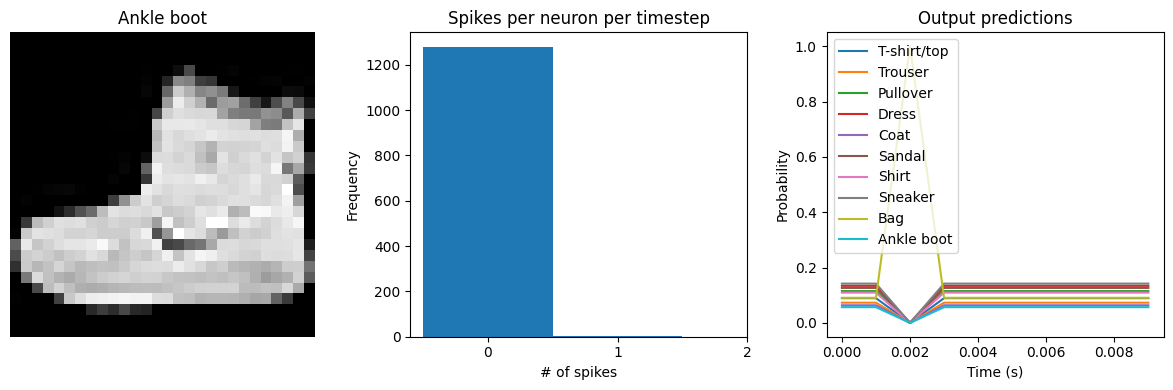

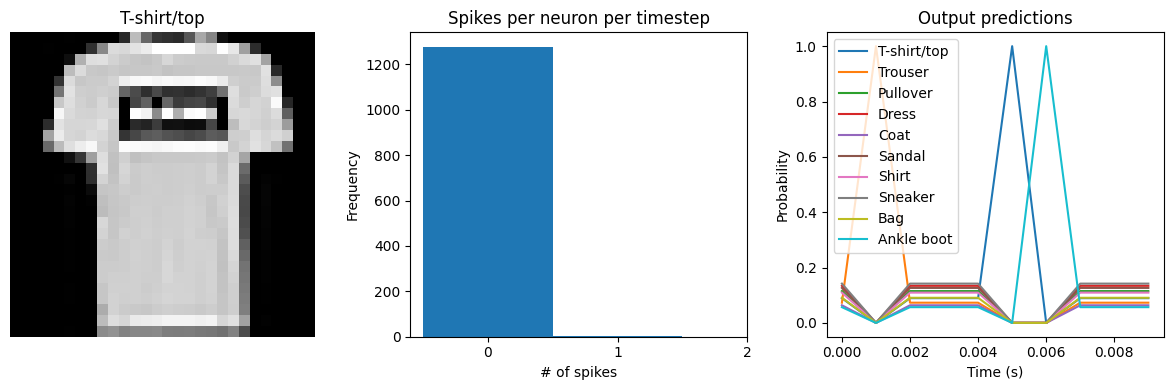

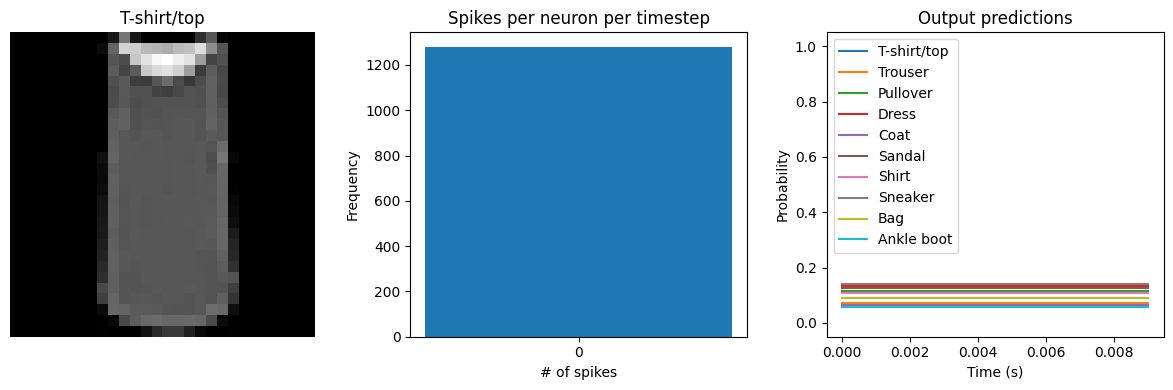

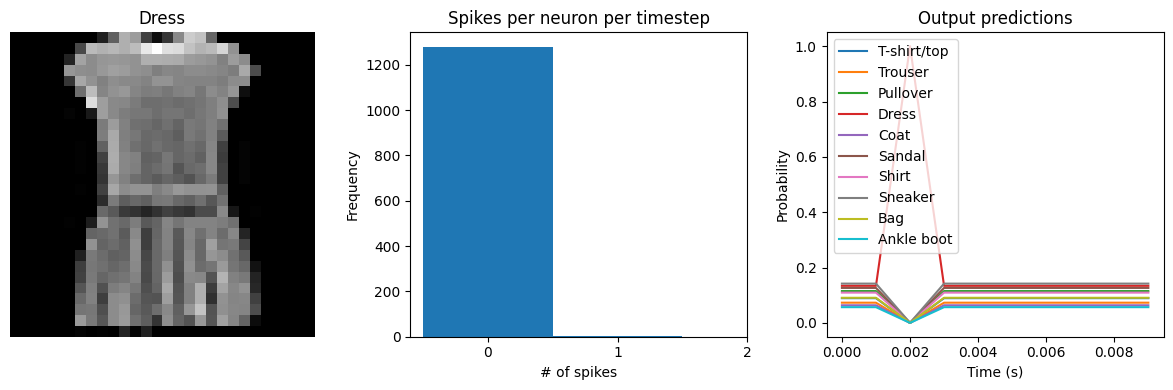

In [ ]:
check_output(spiking_model)

Test accuracy: 64.27
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=30.00


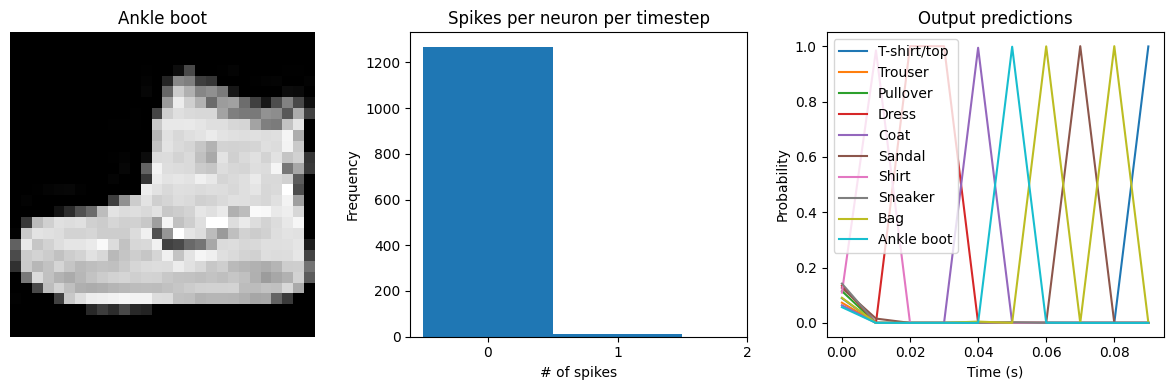

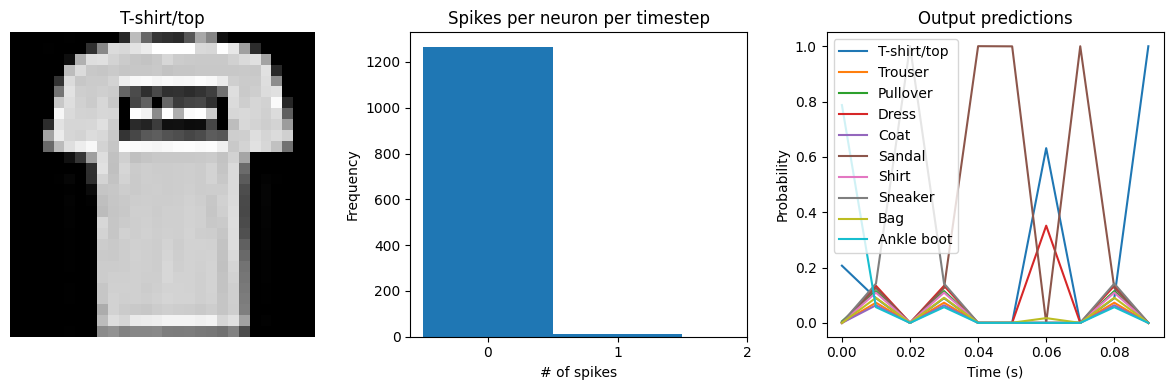

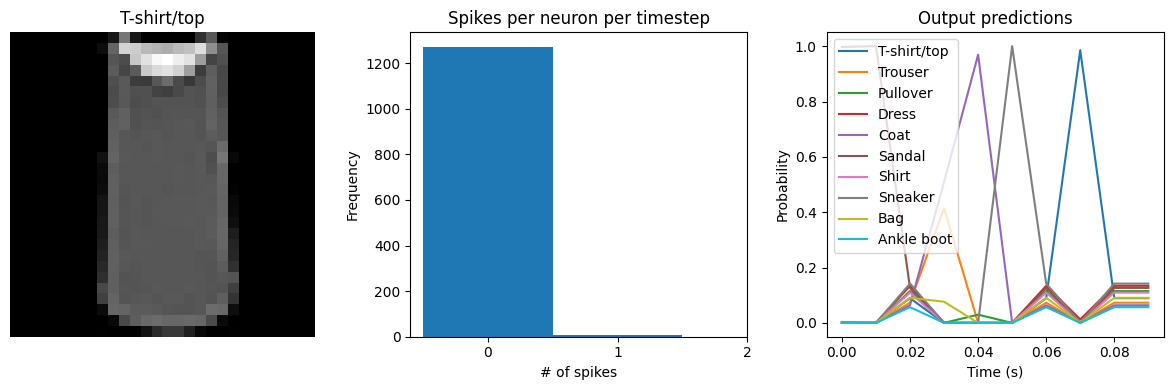

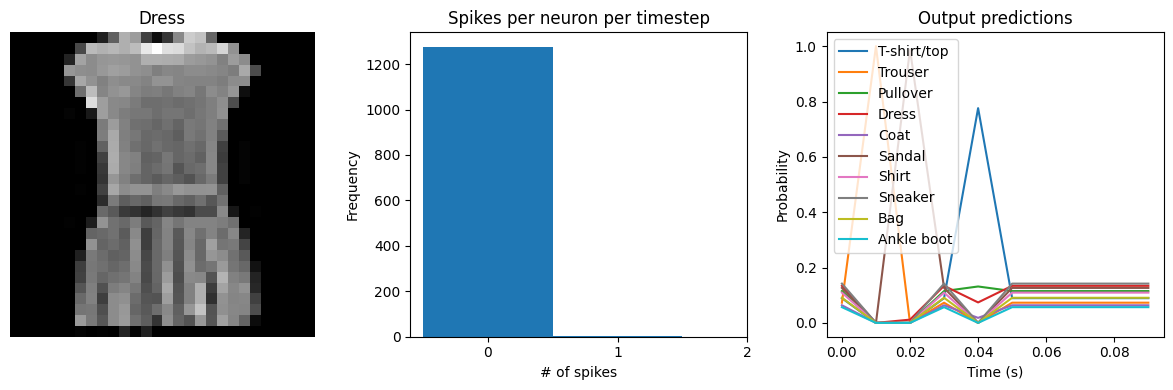

In [ ]:
# dt=0.01 * 10 timesteps is equivalent to 0.1s of simulated time
check_output(spiking_model, modify_dt=0.01)

Test accuracy: 90.00
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=25.00


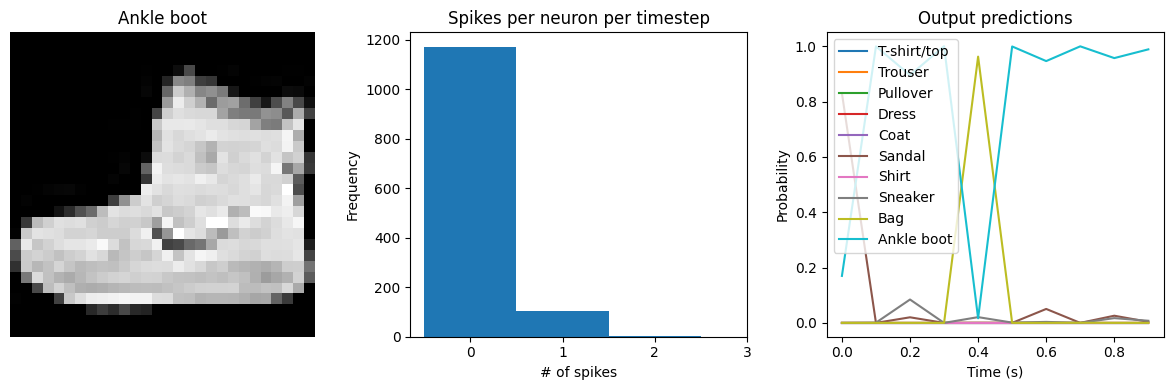

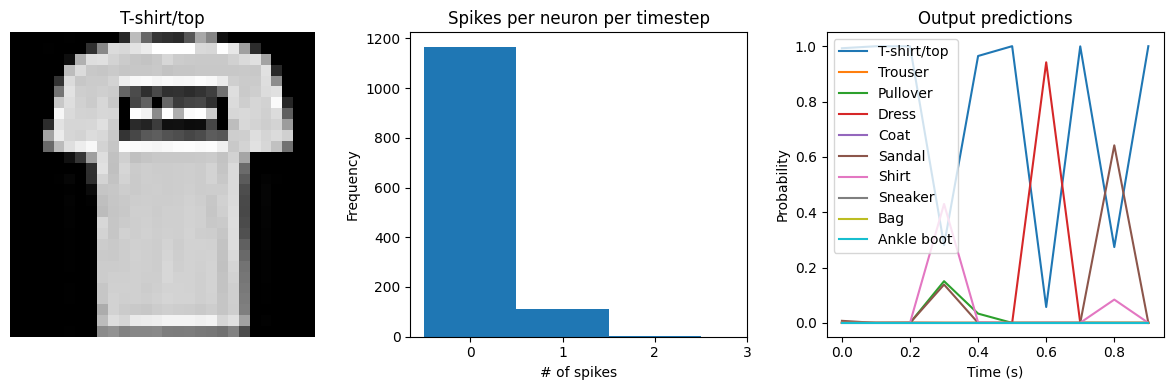

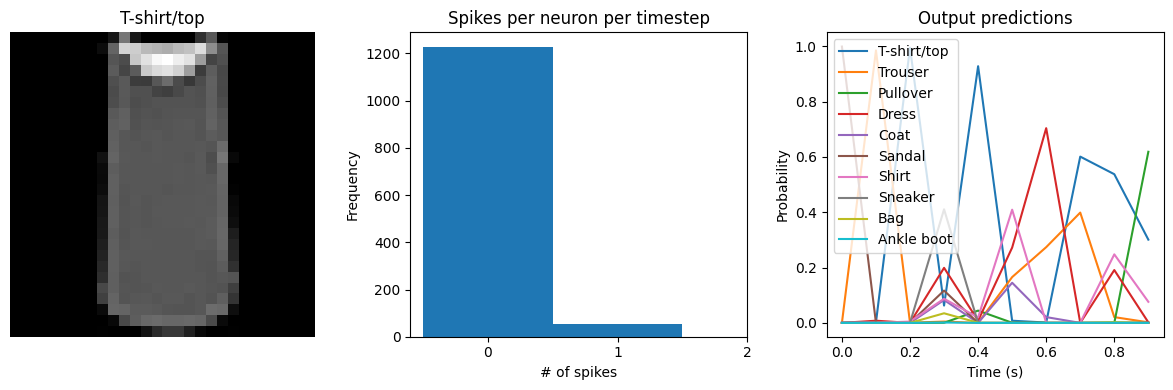

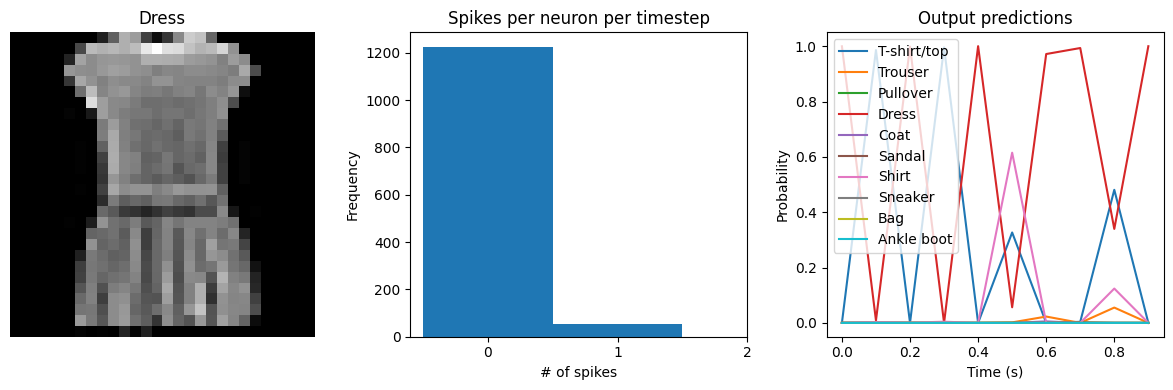

In [ ]:
check_output(spiking_model, modify_dt=0.1)

Test accuracy: 90.49
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=24.60


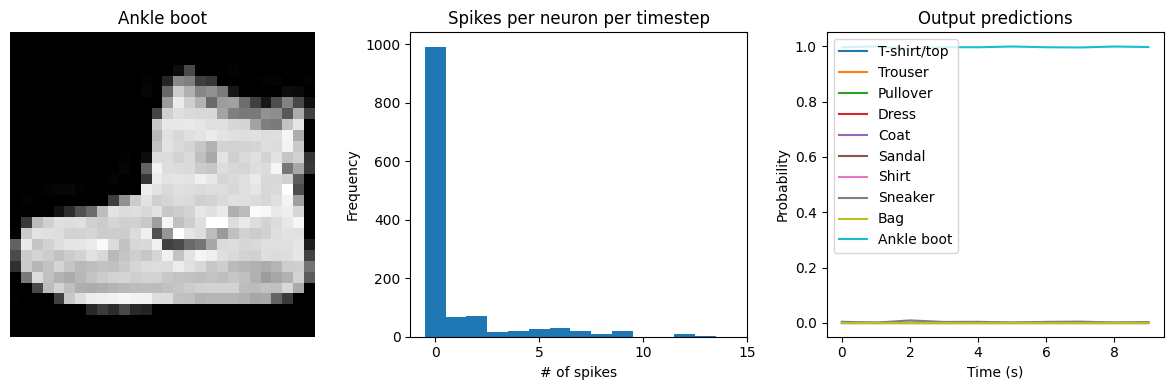

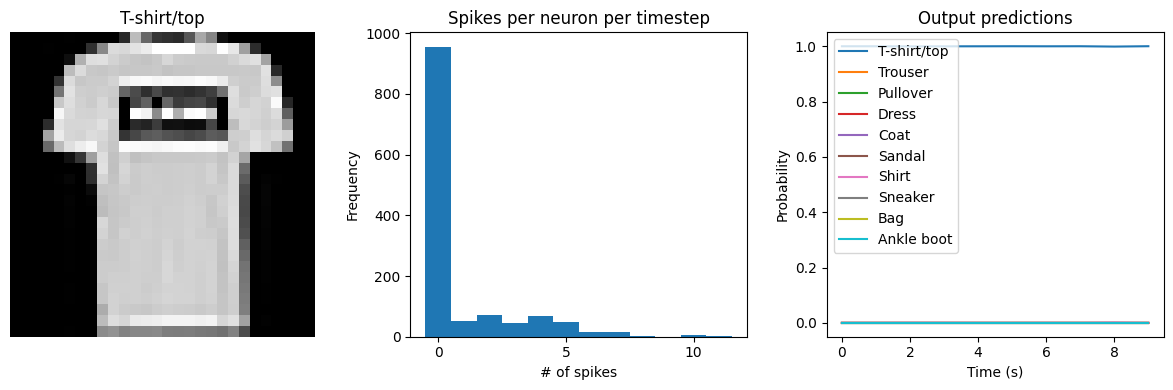

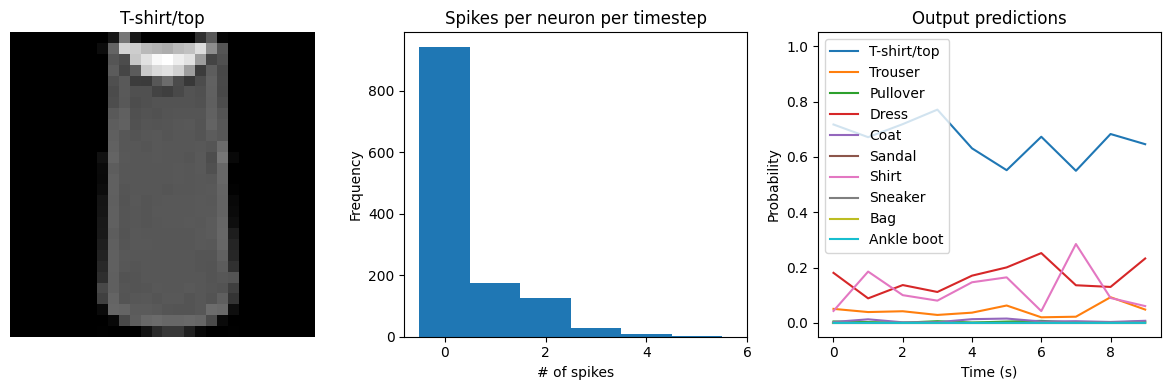

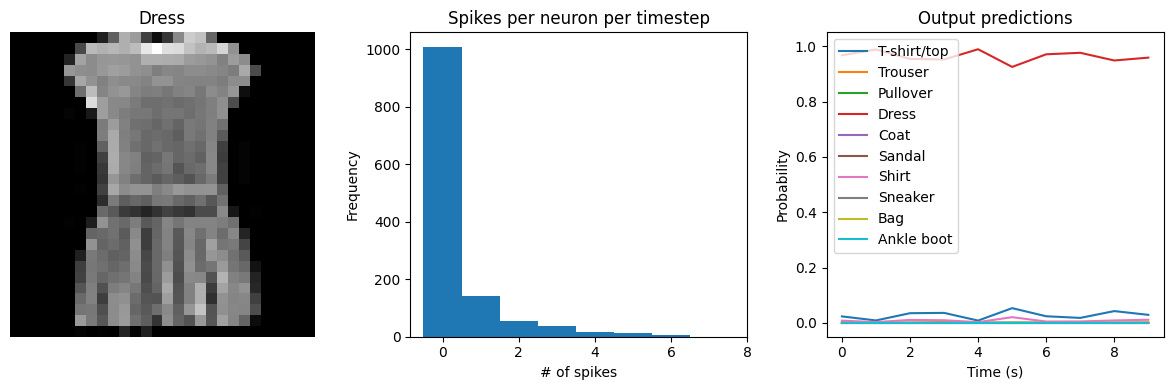

In [ ]:
check_output(spiking_model, modify_dt=1)

Test accuracy: 90.40
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=24.50


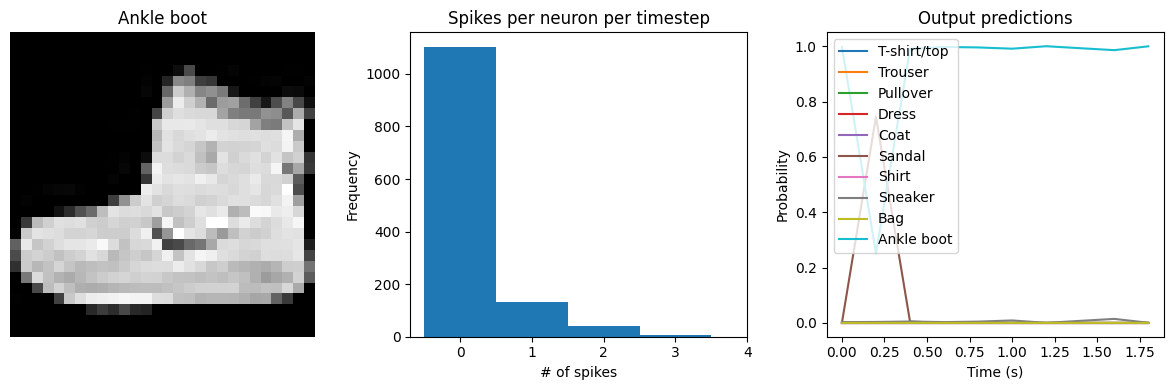

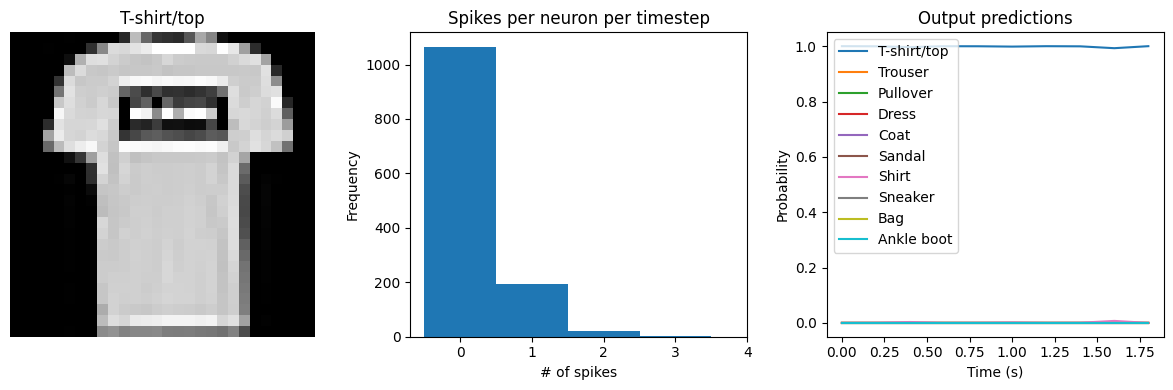

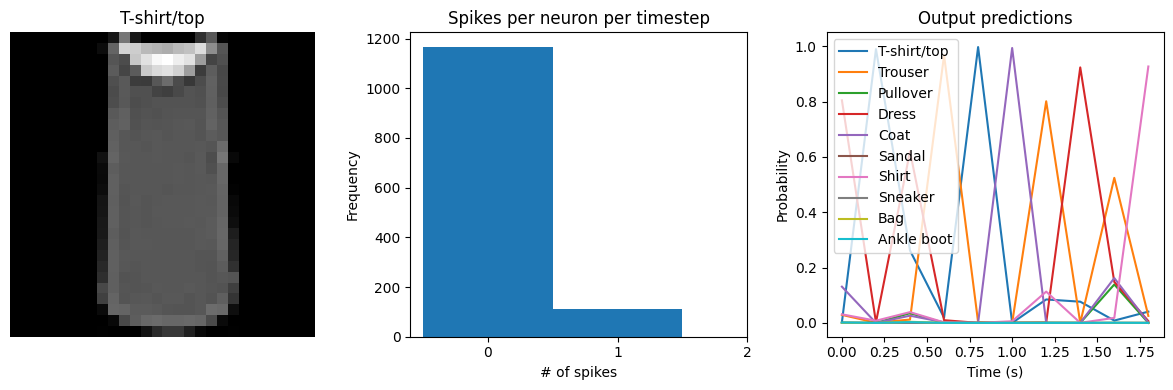

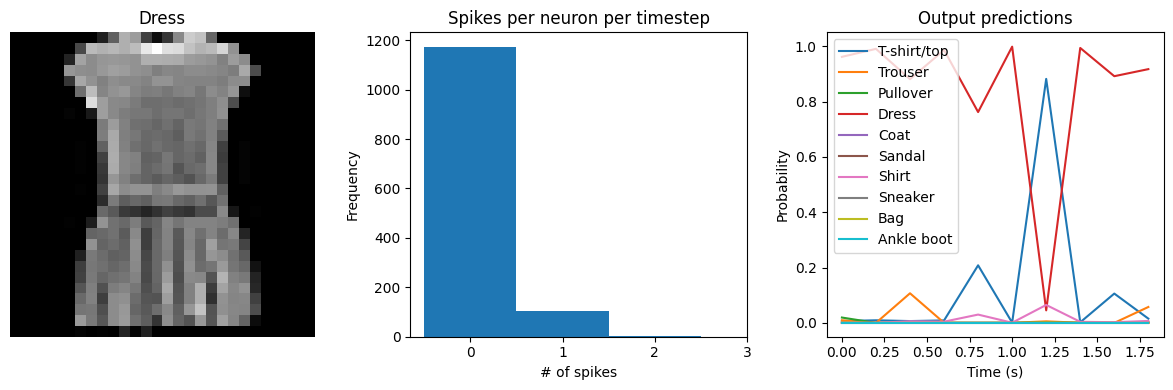

In [ ]:
check_output(spiking_model, modify_dt=0.2)

Test accuracy: 85.54
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=26.67


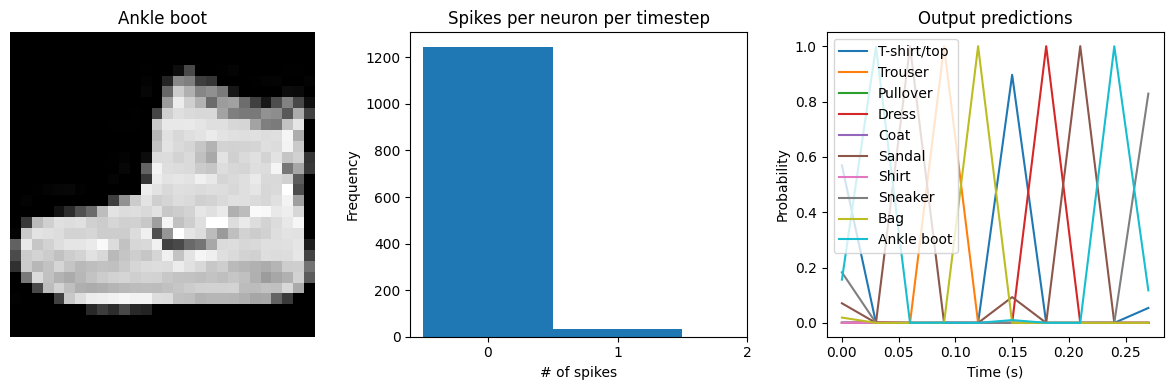

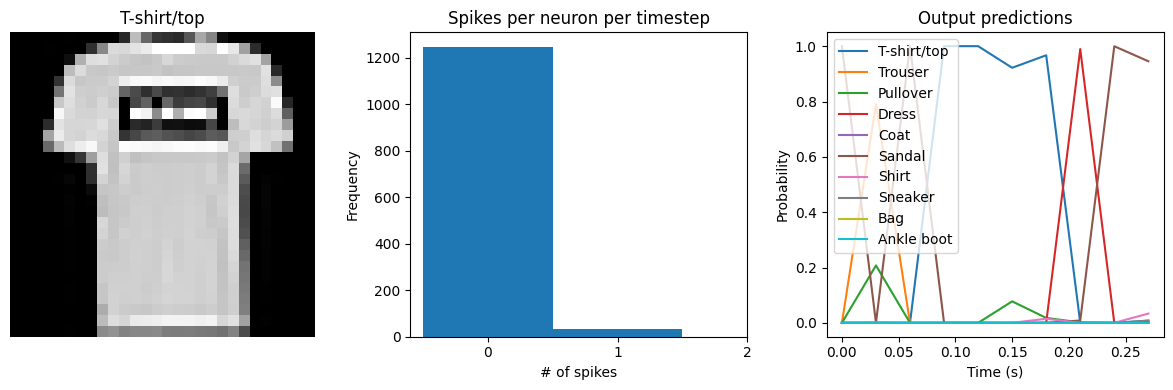

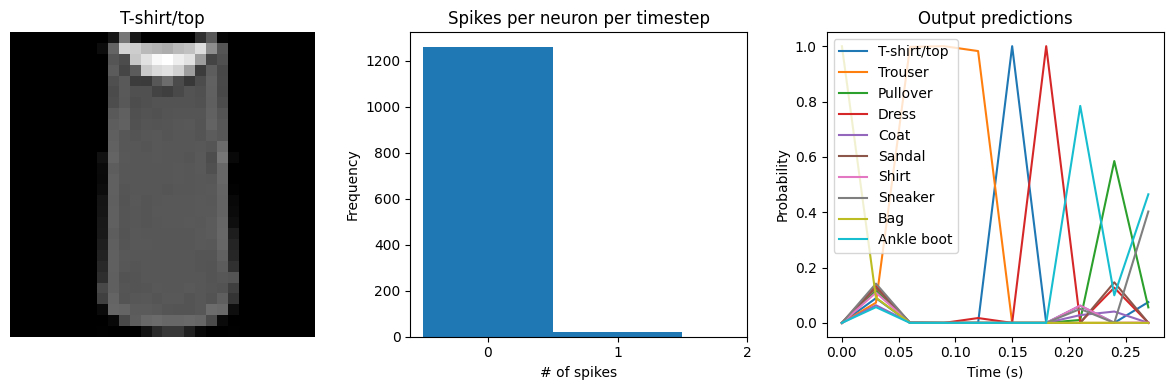

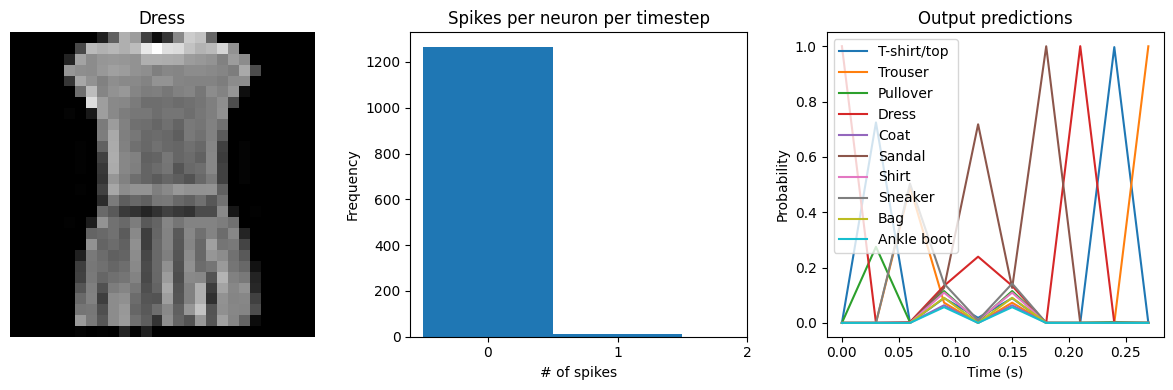

In [ ]:
check_output(spiking_model, modify_dt=0.03)

Test accuracy: 90.49
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=24.71


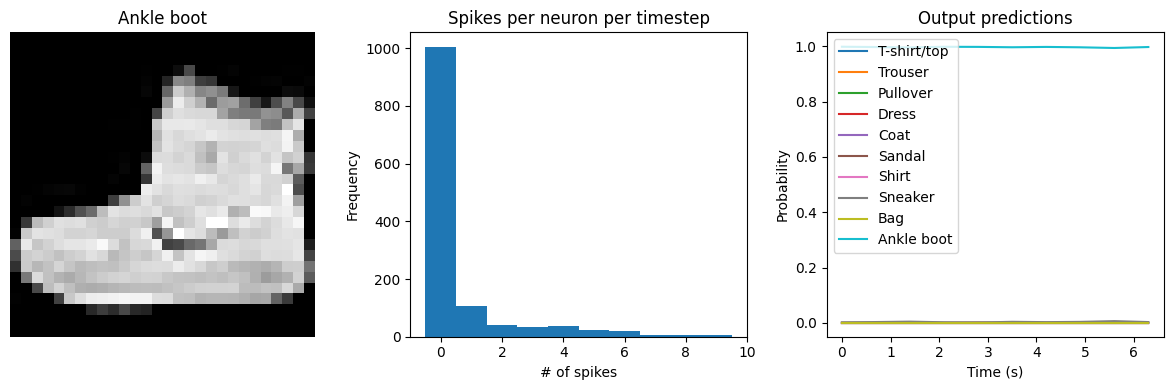

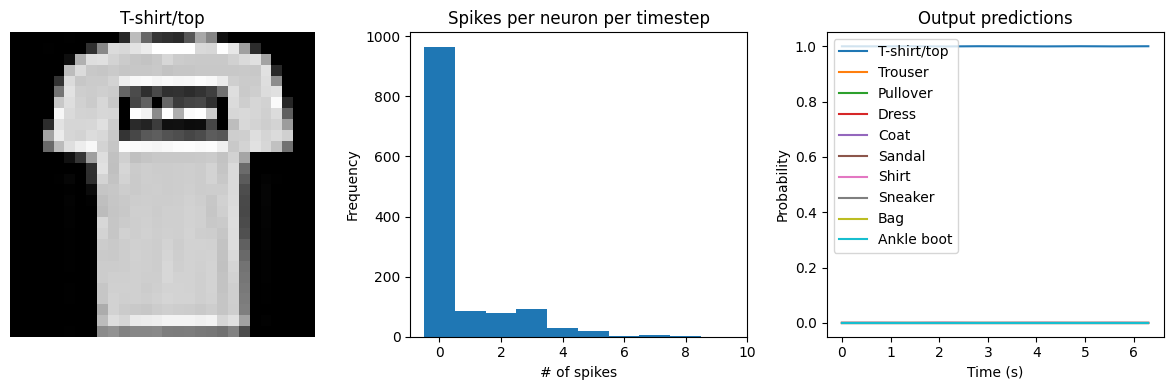

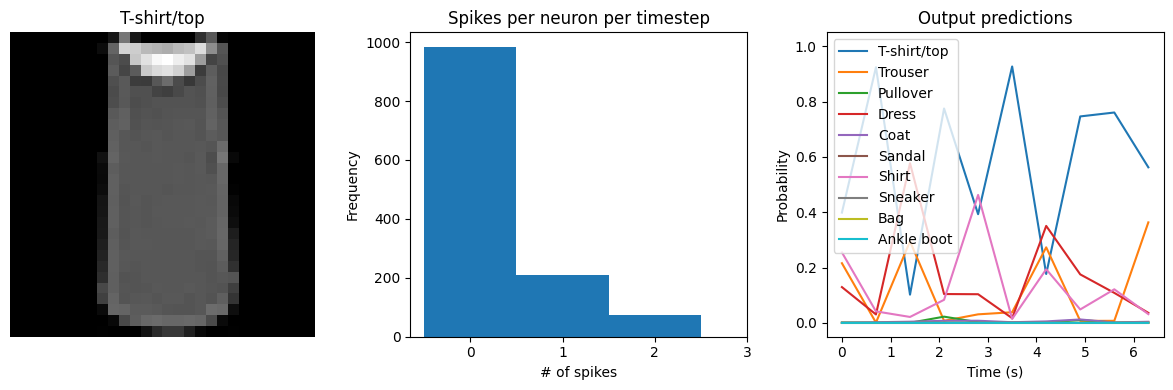

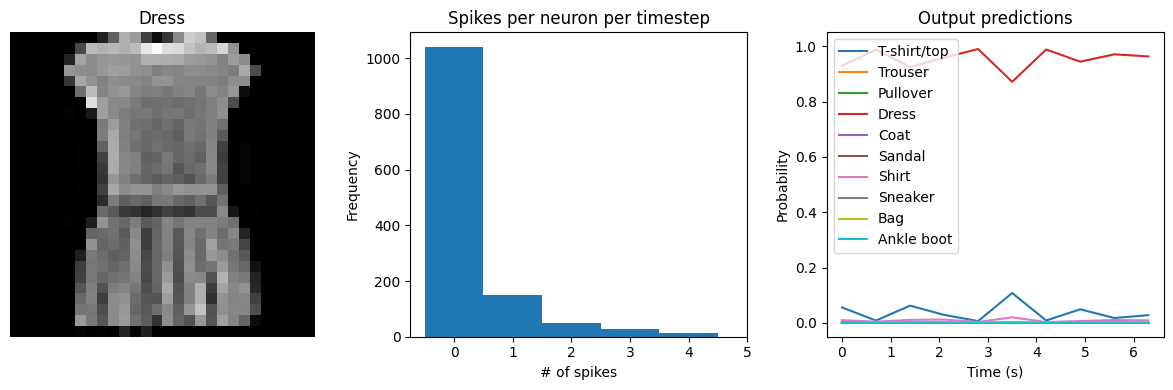

In [ ]:
check_output(spiking_model, modify_dt=0.7)

In [ ]:
spikeaware_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ReLU(), dt=0.01, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7009666562080383
Accuracy(Training) (1): 0.7855666875839233
Accuracy(Training) (2): 0.8082833290100098
Accuracy(Training) (3): 0.8193833231925964
Accuracy(Training) (4): 0.8285666704177856
Accuracy(Training) (5): 0.8344666957855225
Accuracy(Training) (6): 0.8378833532333374
Accuracy(Training) (7): 0.8436499834060669
Accuracy(Training) (8): 0.8478666543960571
Accuracy(Training) (9): 0.8503999710083008
Accuracy(Testing) 0.8513166904449463


Test accuracy: 85.45
Spike rate per neuron (Hz): min=0.00 mean=2.75 max=70.00


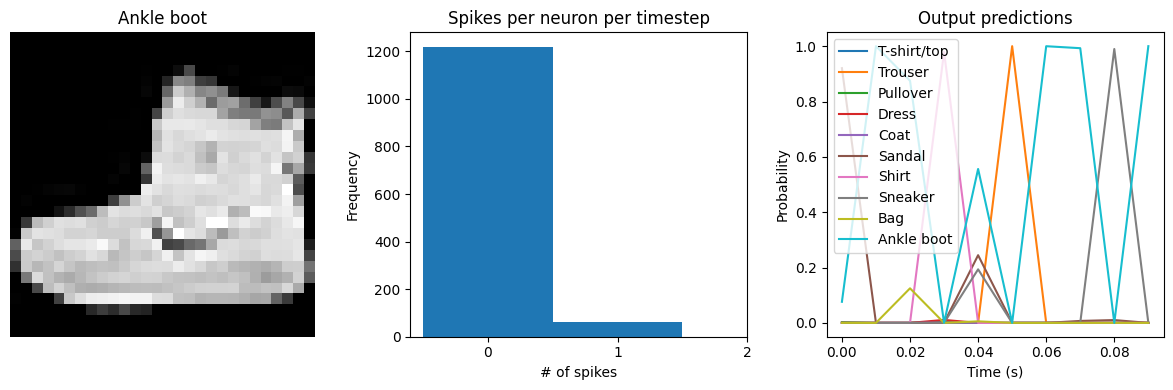

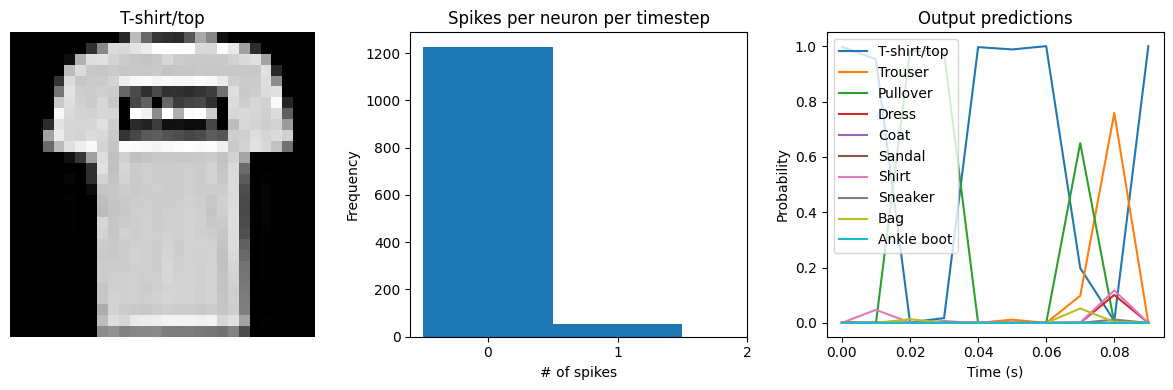

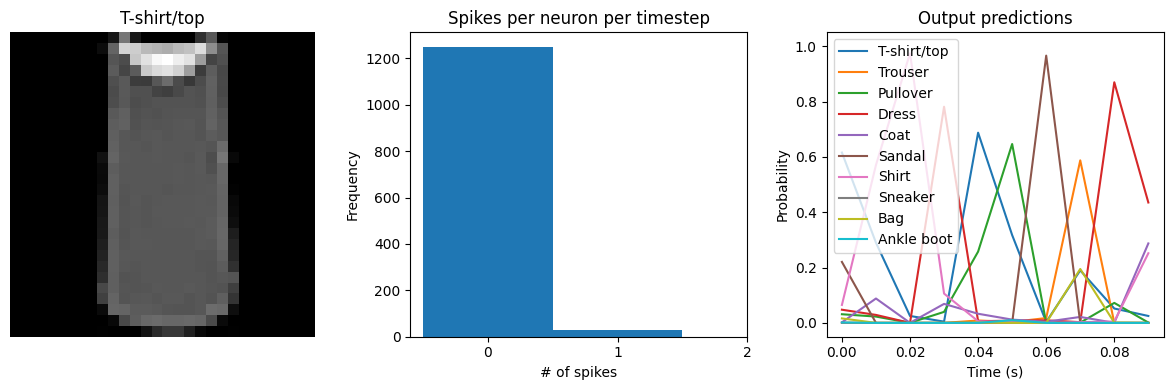

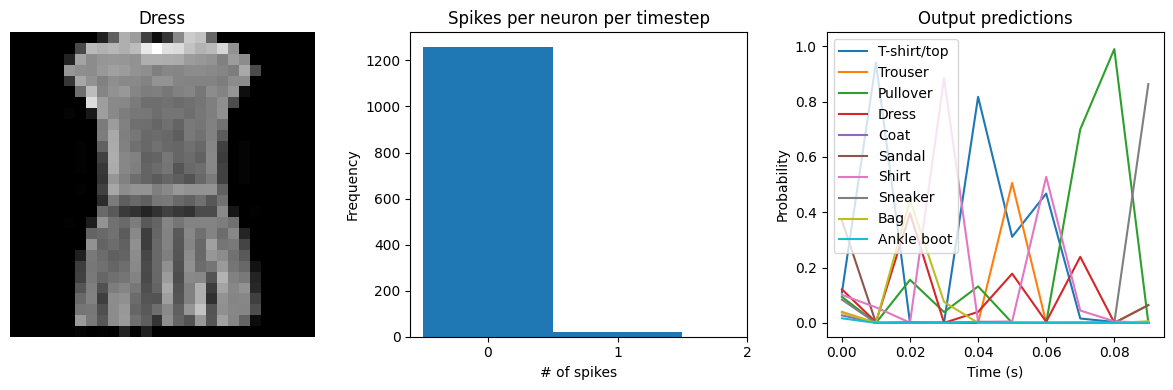

In [ ]:
check_output(spikeaware_model)

In [ ]:
spikeaware_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Sigmoid(), dt=0.01, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.5289833545684814
Accuracy(Training) (1): 0.6240833401679993
Accuracy(Training) (2): 0.6405166387557983
Accuracy(Training) (3): 0.650433361530304
Accuracy(Training) (4): 0.6582333445549011
Accuracy(Training) (5): 0.6633166670799255
Accuracy(Training) (6): 0.6694333553314209
Accuracy(Training) (7): 0.6702666878700256
Accuracy(Training) (8): 0.6711333394050598
Accuracy(Training) (9): 0.6745833158493042
Accuracy(TestING) 0.6785500049591064


In [ ]:
spikeaware_model2 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.LeakyReLU(negative_slope=0.01), dt=0.01, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model2, train_stream, test_stream)

Accuracy(Training) (0): 0.7052833437919617
Accuracy(Training) (1): 0.7889166474342346
Accuracy(Training) (2): 0.809149980545044
Accuracy(Training) (3): 0.8225333094596863
Accuracy(Training) (4): 0.8309166431427002
Accuracy(Training) (5): 0.8359000086784363
Accuracy(Training) (6): 0.8410666584968567
Accuracy(Training) (7): 0.8449333310127258
Accuracy(Training) (8): 0.8483999967575073
Accuracy(Training) (9): 0.8515833616256714
Accuracy(TestING) 0.8550833463668823


In [ ]:
spikeaware_model3 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.LeakyReLU(negative_slope=0.01), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model3, train_stream, test_stream)

Accuracy(Training) (0): 0.7974166870117188
Accuracy(Training) (1): 0.8483833074569702
Accuracy(Training) (2): 0.8615833520889282
Accuracy(Training) (3): 0.8684999942779541
Accuracy(Training) (4): 0.8756999969482422
Accuracy(Training) (5): 0.8805666565895081
Accuracy(Training) (6): 0.8866666555404663
Accuracy(Training) (7): 0.8891333341598511
Accuracy(Training) (8): 0.8924499750137329
Accuracy(Training) (9): 0.8967666625976562
Accuracy(TestING) 0.8951833248138428


In [ ]:
spikeaware_model4 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.LeakyReLU(negative_slope=0.06), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model4, train_stream, test_stream)

Accuracy(Training) (0): 0.8009666800498962
Accuracy(Training) (1): 0.8456833362579346
Accuracy(Training) (2): 0.859250009059906
Accuracy(Training) (3): 0.8677833080291748
Accuracy(Training) (4): 0.871916651725769
Accuracy(Training) (5): 0.8769833445549011
Accuracy(Training) (6): 0.8819500207901001
Accuracy(Training) (7): 0.883983314037323
Accuracy(Training) (8): 0.8880000114440918
Accuracy(Training) (9): 0.890250027179718
Accuracy(TestING) 0.8873500227928162


In [ ]:
spikeaware_model5 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SiLU(), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model5, train_stream, test_stream)

Accuracy(Training) (0): 0.7999833226203918
Accuracy(Training) (1): 0.8464000225067139
Accuracy(Training) (2): 0.8593000173568726
Accuracy(Training) (3): 0.8679500222206116
Accuracy(Training) (4): 0.8745333552360535
Accuracy(Training) (5): 0.8801833391189575
Accuracy(Training) (6): 0.8863000273704529
Accuracy(Training) (7): 0.8899999856948853
Accuracy(Training) (8): 0.8933166861534119
Accuracy(Training) (9): 0.8951333165168762
Accuracy(TestING) 0.8964833617210388


In [ ]:
spikeaware_model6 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.PReLU(num_parameters=1, init=0.25), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model6, train_stream, test_stream)

Accuracy(Training) (0): 0.7957166433334351
Accuracy(Training) (1): 0.8400333523750305
Accuracy(Training) (2): 0.8518166542053223
Accuracy(Training) (3): 0.8597999811172485
Accuracy(Training) (4): 0.8638166785240173
Accuracy(Training) (5): 0.8695166707038879
Accuracy(Training) (6): 0.8721833229064941
Accuracy(Training) (7): 0.8751333355903625
Accuracy(Training) (8): 0.8772000074386597
Accuracy(Training) (9): 0.8797833323478699
Accuracy(TestING) 0.8843166828155518


In [ ]:
spikeaware_model7 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.PReLU(num_parameters=1, init=0.05), dt=0.05, spiking_aware_training=True #parametric ReLu
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model7, train_stream, test_stream)

Accuracy(Training) (0): 0.7998833060264587
Accuracy(Training) (1): 0.845466673374176
Accuracy(Training) (2): 0.8583333492279053
Accuracy(Training) (3): 0.8673666715621948
Accuracy(Training) (4): 0.8749833106994629
Accuracy(Training) (5): 0.8792499899864197
Accuracy(Training) (6): 0.8826000094413757
Accuracy(Training) (7): 0.885450005531311
Accuracy(Training) (8): 0.8891000151634216
Accuracy(Training) (9): 0.8914666771888733
Accuracy(TestING) 0.8941500186920166


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.PReLU(num_parameters=1, init=0.05), dt=0.05, spiking_aware_training=True #parametric ReLu
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.70291668176651
Accuracy(Training) (1): 0.7185999751091003
Accuracy(Training) (2): 0.7337166666984558
Accuracy(Training) (3): 0.7571499943733215
Accuracy(Training) (4): 0.756600022315979
Accuracy(Training) (5): 0.7817833423614502
Accuracy(Training) (6): 0.7871500253677368
Accuracy(Training) (7): 0.7965499758720398
Accuracy(Training) (8): 0.7981833219528198
Accuracy(Training) (9): 0.8149833083152771
Accuracy(Training) (10): 0.8086333274841309
Accuracy(Training) (11): 0.803933322429657
Accuracy(Training) (12): 0.8184666633605957
Accuracy(Training) (13): 0.8120666742324829
Accuracy(Training) (14): 0.8197333216667175
Accuracy(Training) (15): 0.8163333535194397
Accuracy(Training) (16): 0.8226000070571899
Accuracy(Training) (17): 0.8282333612442017
Accuracy(Training) (18): 0.8251500129699707
Accuracy(Training) (19): 0.8337166905403137
Accuracy(Training) (20): 0.8288999795913696
Accuracy(Training) (21): 0.8370166420936584
Accuracy(Training) (22): 0.8354666829109192
Ac

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SiLU(), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.7081500291824341
Accuracy(Training) (1): 0.7246000170707703
Accuracy(Training) (2): 0.7545833587646484
Accuracy(Training) (3): 0.7559999823570251
Accuracy(Training) (4): 0.7726333141326904
Accuracy(Training) (5): 0.7764666676521301
Accuracy(Training) (6): 0.7687666416168213
Accuracy(Training) (7): 0.7864000201225281
Accuracy(Training) (8): 0.799049973487854
Accuracy(Training) (9): 0.792033314704895
Accuracy(Training) (10): 0.8014333248138428
Accuracy(Training) (11): 0.8140000104904175
Accuracy(Training) (12): 0.8156999945640564
Accuracy(Training) (13): 0.8139333128929138
Accuracy(Training) (14): 0.8206999897956848
Accuracy(Training) (15): 0.8196666836738586
Accuracy(Training) (16): 0.8255333304405212
Accuracy(Training) (17): 0.8195833563804626
Accuracy(Training) (18): 0.8285166621208191
Accuracy(Training) (19): 0.8289666771888733
Accuracy(Training) (20): 0.8237500190734863
Accuracy(Training) (21): 0.8324999809265137
Accuracy(Training) (22): 0.8359166383743286


In [ ]:
spikeaware_model8 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.05, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model8, train_stream, test_stream)

Accuracy(Training) (0): 0.8000333309173584
Accuracy(Training) (1): 0.8425333499908447
Accuracy(Training) (2): 0.8549166917800903
Accuracy(Training) (3): 0.8623999953269958
Accuracy(Training) (4): 0.8668000102043152
Accuracy(Training) (5): 0.8732166886329651
Accuracy(Training) (6): 0.87663334608078
Accuracy(Training) (7): 0.8809000253677368
Accuracy(Training) (8): 0.8831333518028259
Accuracy(Training) (9): 0.8859333395957947
Accuracy(TestING) 0.8863499760627747


In [ ]:
spikeaware_model9 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.01, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model9, train_stream, test_stream)

Accuracy(Training) (0): 0.7141166925430298
Accuracy(Training) (1): 0.7879999876022339
Accuracy(Training) (2): 0.8100666403770447
Accuracy(Training) (3): 0.8200500011444092
Accuracy(Training) (4): 0.8275166749954224
Accuracy(Training) (5): 0.8330833315849304
Accuracy(Training) (6): 0.8365499973297119
Accuracy(Training) (7): 0.8410666584968567
Accuracy(Training) (8): 0.8447666764259338
Accuracy(Training) (9): 0.847100019454956
Accuracy(TestING) 0.8516333103179932


In [ ]:
spikeaware_model10 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model10, train_stream, test_stream)

Accuracy(Training) (0): 0.8125166893005371
Accuracy(Training) (1): 0.8540833592414856
Accuracy(Training) (2): 0.8667333126068115
Accuracy(Training) (3): 0.8752333521842957
Accuracy(Training) (4): 0.8824999928474426
Accuracy(Training) (5): 0.8881833553314209
Accuracy(Training) (6): 0.8921833038330078
Accuracy(Training) (7): 0.8972166776657104
Accuracy(Training) (8): 0.9002166390419006
Accuracy(Training) (9): 0.9039166569709778
Training time: 58.16715145111084
Accuracy(Testing) 0.8997499942779541
Testing/Simulation time 60.9557409286499


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8201833367347717
Accuracy(Training) (1): 0.8600333333015442
Accuracy(Training) (2): 0.8731499910354614
Accuracy(Training) (3): 0.8820000290870667
Accuracy(Training) (4): 0.8889666795730591
Accuracy(Training) (5): 0.8948666453361511
Accuracy(Training) (6): 0.9000166654586792
Accuracy(Training) (7): 0.9039333462715149
Accuracy(Training) (8): 0.9081833362579346
Accuracy(Training) (9): 0.9121999740600586
Training time: 58.34246611595154
Accuracy(Testing) 0.9090499877929688
Testing/Simulation time 60.68090534210205


In [ ]:
spikeaware_model12 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=0.8), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model12, train_stream, test_stream)

Accuracy(Training) (0): 0.8214499950408936
Accuracy(Training) (1): 0.8636166453361511
Accuracy(Training) (2): 0.8752999901771545
Accuracy(Training) (3): 0.8843166828155518
Accuracy(Training) (4): 0.8915166854858398
Accuracy(Training) (5): 0.8977333307266235
Accuracy(Training) (6): 0.9022666811943054
Accuracy(Training) (7): 0.9059666395187378
Accuracy(Training) (8): 0.910266637802124
Accuracy(Training) (9): 0.9136833548545837
Training time: 58.193233251571655
Accuracy(Testing) 0.9142166376113892
Testing/Simulation time 60.88551449775696


In [ ]:
spikeaware_model13 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.7, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model13, train_stream, test_stream)

Accuracy(Training) (0): 0.8207499980926514
Accuracy(Training) (1): 0.8614000082015991
Accuracy(Training) (2): 0.8742833137512207
Accuracy(Training) (3): 0.8826833367347717
Accuracy(Training) (4): 0.8895000219345093
Accuracy(Training) (5): 0.8949666619300842
Accuracy(Training) (6): 0.8995833396911621
Accuracy(Training) (7): 0.9044166803359985
Accuracy(Training) (8): 0.9082833528518677
Accuracy(Training) (9): 0.9114000201225281
Accuracy(TestING) 0.909600019454956


In [ ]:
spikeaware_model12 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=0.8), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model12, train_stream, test_stream)

Accuracy(Training) (0): 0.8213499784469604
Accuracy(Training) (1): 0.8628833293914795
Accuracy(Training) (2): 0.875166654586792
Accuracy(Training) (3): 0.8837000131607056
Accuracy(Training) (4): 0.8907166719436646
Accuracy(Training) (5): 0.8966166377067566
Accuracy(Training) (6): 0.9014166593551636
Accuracy(Training) (7): 0.9056833386421204
Accuracy(Training) (8): 0.9101666808128357
Accuracy(Training) (9): 0.9145166873931885
Training time: 58.10046052932739
Accuracy(Testing) 0.9093000292778015
Testing/Simulation time 60.460548877716064


In [ ]:
spikeaware_model14 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.2), dt=0.65, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model14, train_stream, test_stream)

Accuracy(Training) (0): 0.8209999799728394
Accuracy(Training) (1): 0.8607666492462158
Accuracy(Training) (2): 0.8731333613395691
Accuracy(Training) (3): 0.8825333118438721
Accuracy(Training) (4): 0.8895666599273682
Accuracy(Training) (5): 0.8947499990463257
Accuracy(Training) (6): 0.9003166556358337
Accuracy(Training) (7): 0.9048666954040527
Accuracy(Training) (8): 0.9085000157356262
Accuracy(Training) (9): 0.9124000072479248
Training time: 58.79070520401001
Accuracy(Testing) 0.9101499915122986
Testing/Simulation time 61.14545035362244


In [ ]:
spikeaware_model15 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.65, spiking_aware_training=True #exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model15, train_stream, test_stream)

Accuracy(Training) (0): 0.8204500079154968
Accuracy(Training) (1): 0.8608333468437195
Accuracy(Training) (2): 0.8740833401679993
Accuracy(Training) (3): 0.8825500011444092
Accuracy(Training) (4): 0.8891333341598511
Accuracy(Training) (5): 0.8942000269889832
Accuracy(Training) (6): 0.9004999995231628
Accuracy(Training) (7): 0.9043166637420654
Accuracy(Training) (8): 0.9090499877929688
Accuracy(Training) (9): 0.9126833081245422
Accuracy(TestING) 0.9106333255767822


In [ ]:
spikeaware_model16 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SELU(), dt=0.65, spiking_aware_training=True #scaled exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model16, train_stream, test_stream)

Accuracy(Training) (0): 0.8215000033378601
Accuracy(Training) (1): 0.859499990940094
Accuracy(Training) (2): 0.8720666766166687
Accuracy(Training) (3): 0.8798999786376953
Accuracy(Training) (4): 0.8865000009536743
Accuracy(Training) (5): 0.8916333317756653
Accuracy(Training) (6): 0.8958666920661926
Accuracy(Training) (7): 0.900950014591217
Accuracy(Training) (8): 0.9043166637420654
Accuracy(Training) (9): 0.9088166952133179
Accuracy(TestING) 0.9048333168029785


In [ ]:
spikeaware_model17 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SELU(), dt=0.15, spiking_aware_training=True #scaled exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model17, train_stream, test_stream)

Accuracy(Training) (0): 0.8184166550636292
Accuracy(Training) (1): 0.8554166555404663
Accuracy(Training) (2): 0.8677499890327454
Accuracy(Training) (3): 0.8753499984741211
Accuracy(Training) (4): 0.8816999793052673
Accuracy(Training) (5): 0.8870999813079834
Accuracy(Training) (6): 0.8919666409492493
Accuracy(Training) (7): 0.8957499861717224
Accuracy(Training) (8): 0.8987500071525574
Accuracy(Training) (9): 0.9023500084877014
Accuracy(Testing) 0.9006500244140625


In [ ]:
spikeaware_model18 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SELU(), dt=0.05, spiking_aware_training=True #scaled exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model18, train_stream, test_stream)

Accuracy(Training) (0): 0.8031833171844482
Accuracy(Training) (1): 0.8428833484649658
Accuracy(Training) (2): 0.8554333448410034
Accuracy(Training) (3): 0.8632166385650635
Accuracy(Training) (4): 0.8690666556358337
Accuracy(Training) (5): 0.8745333552360535
Accuracy(Training) (6): 0.878433346748352
Accuracy(Training) (7): 0.8806833624839783
Accuracy(Training) (8): 0.8849999904632568
Accuracy(Training) (9): 0.8882833123207092
Accuracy(Testing) 0.8912166953086853


In [ ]:
spikeaware_model19 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SELU(), dt=0.4, spiking_aware_training=True #scaled exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model19, train_stream, test_stream)

Accuracy(Training) (0): 0.820900022983551
Accuracy(Training) (1): 0.8583999872207642
Accuracy(Training) (2): 0.869949996471405
Accuracy(Training) (3): 0.8787833452224731
Accuracy(Training) (4): 0.8862166404724121
Accuracy(Training) (5): 0.8914666771888733
Accuracy(Training) (6): 0.8962666392326355
Accuracy(Training) (7): 0.9006500244140625
Accuracy(Training) (8): 0.9047499895095825
Accuracy(Training) (9): 0.9082333445549011
Accuracy(Testing) 0.908383309841156


In [ ]:
spikeaware_model20 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SELU(), dt=0.35, spiking_aware_training=True #scaled exponential linear unit
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model20, train_stream, test_stream)

Accuracy(Training) (0): 0.8216166496276855
Accuracy(Training) (1): 0.8582666516304016
Accuracy(Training) (2): 0.8711166381835938
Accuracy(Training) (3): 0.8790666460990906
Accuracy(Training) (4): 0.885699987411499
Accuracy(Training) (5): 0.8899499773979187
Accuracy(Training) (6): 0.8956000208854675
Accuracy(Training) (7): 0.9000999927520752
Accuracy(Training) (8): 0.902999997138977
Accuracy(Training) (9): 0.9068999886512756
Accuracy(Testing) 0.9068166613578796


In [ ]:
spikeaware_model21 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), dt=0.35, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model21, train_stream, test_stream)

Accuracy(Training) (0): 0.8217666745185852
Accuracy(Training) (1): 0.8638333082199097
Accuracy(Training) (2): 0.878433346748352
Accuracy(Training) (3): 0.886900007724762
Accuracy(Training) (4): 0.8930333256721497
Accuracy(Training) (5): 0.9006333351135254
Accuracy(Training) (6): 0.9050166606903076
Accuracy(Training) (7): 0.9090666770935059
Accuracy(Training) (8): 0.9132999777793884
Accuracy(Training) (9): 0.9174500107765198
Accuracy(Testing) 0.897350013256073


In [ ]:
spikeaware_model22 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Mish(), dt=0.35, spiking_aware_training=False
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model22, train_stream, test_stream)

Accuracy(Training) (0): 0.8223833441734314
Accuracy(Training) (1): 0.8650166392326355
Accuracy(Training) (2): 0.8785666823387146
Accuracy(Training) (3): 0.8876500129699707
Accuracy(Training) (4): 0.8949833512306213
Accuracy(Training) (5): 0.9012500047683716
Accuracy(Training) (6): 0.9065333604812622
Accuracy(Training) (7): 0.9110666513442993
Accuracy(Training) (8): 0.9153000116348267
Accuracy(Testing) 0.9087166786193848
Testing/Simulation time 153.2840769290924


In [ ]:
spikeaware_model23 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model23, train_stream, test_stream)

Accuracy(Training) (0): 0.8035333156585693
Accuracy(Training) (1): 0.848550021648407
Accuracy(Training) (2): 0.8614833354949951
Accuracy(Training) (3): 0.8721333146095276
Accuracy(Training) (4): 0.878166675567627
Accuracy(Training) (5): 0.8839499950408936
Accuracy(Training) (6): 0.8883833289146423
Accuracy(Training) (7): 0.8931000232696533
Accuracy(Training) (8): 0.89451664686203
Accuracy(Training) (9): 0.8978999853134155
Training time: 129.92344427108765
Accuracy(Testing) 0.8967000246047974
Testing/Simulation time 136.1905074119568


In [ ]:
spikeaware_model24 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=20), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model24, train_stream, test_stream)

Accuracy(Training) (0): 0.7910500168800354
Accuracy(Training) (1): 0.8413500189781189
Accuracy(Training) (2): 0.8545833230018616
Accuracy(Training) (3): 0.8647333383560181
Accuracy(Training) (4): 0.8712833523750305
Accuracy(Training) (5): 0.8780999779701233
Accuracy(Training) (6): 0.8812166452407837
Accuracy(Training) (7): 0.8852499723434448
Accuracy(Training) (8): 0.8881000280380249
Accuracy(Training) (9): 0.8927500247955322
Training time: 99.50916624069214
Accuracy(Testing) 0.8925833106040955
Testing/Simulation time 103.7827045917511


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.7052000164985657
Accuracy(Training) (1): 0.7179999947547913
Accuracy(Training) (2): 0.741516649723053
Accuracy(Training) (3): 0.7501833438873291
Accuracy(Training) (4): 0.7655333280563354
Accuracy(Training) (5): 0.7755500078201294
Accuracy(Training) (6): 0.786383330821991
Accuracy(Training) (7): 0.7967833280563354
Accuracy(Training) (8): 0.802566647529602
Accuracy(Training) (9): 0.803766667842865
Accuracy(Training) (10): 0.8080833554267883
Accuracy(Training) (11): 0.8202333450317383
Accuracy(Training) (12): 0.8140333294868469
Accuracy(Training) (13): 0.8133666515350342
Accuracy(Training) (14): 0.826116681098938
Accuracy(Training) (15): 0.8227166533470154
Accuracy(Training) (16): 0.8279333114624023
Accuracy(Training) (17): 0.8303833603858948
Accuracy(Training) (18): 0.8378666639328003
Accuracy(Training) (19): 0.8381166458129883
Accuracy(Training) (20): 0.8396333456039429
Accuracy(Training) (21): 0.8379166722297668
Accuracy(Training) (22): 0.8419166803359985
Acc

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
        SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.802216649055481
Accuracy(Training) (1): 0.8437666893005371
Accuracy(Training) (2): 0.8546833395957947
Accuracy(Training) (3): 0.8630833625793457
Accuracy(Training) (4): 0.869616687297821
Accuracy(Training) (5): 0.8749333620071411
Accuracy(Training) (6): 0.8804500102996826
Accuracy(Training) (7): 0.883400022983551
Accuracy(Training) (8): 0.8869333267211914
Accuracy(Training) (9): 0.8899000287055969
Accuracy(Training) (10): 0.8916000127792358
Accuracy(Training) (11): 0.8940833210945129
Accuracy(Training) (12): 0.8977000117301941
Accuracy(Training) (13): 0.9003499746322632
Accuracy(Training) (14): 0.8294500112533569
Accuracy(Training) (15): 0.7565833330154419
Accuracy(Training) (16): 0.742733359336853
Accuracy(Training) (17): 0.7387333512306213
Accuracy(Training) (18): 0.7231500148773193
Accuracy(Training) (19): 0.6563166379928589
Early stopping due to no improvement in loss.
Training time: 877.3432466983795
Accuracy(Testing) 0.6656666398048401


In [ ]:
spikeaware_model25 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=10), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10))
train(spikeaware_model25, train_stream, test_stream)

Accuracy(Training) (0): 0.8020166754722595
Accuracy(Training) (1): 0.8444666862487793
Accuracy(Training) (2): 0.8591833114624023
Accuracy(Training) (3): 0.8676666617393494
Accuracy(Training) (4): 0.8736666440963745
Accuracy(Training) (5): 0.8780666589736938
Accuracy(Training) (6): 0.7791500091552734
Accuracy(Training) (7): 0.6227499842643738
Accuracy(Training) (8): 0.6304000020027161
Accuracy(Training) (9): 0.5746833086013794
Accuracy(Training) (10): 0.42809998989105225
Early stopping due to no improvement in loss.
Training time: 479.785706281662
Accuracy(Testing) 0.393449991941452


In [ ]:
spikeaware_model25 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=10), dt=0.05, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model25, train_stream, test_stream)

Accuracy(Training) (0): 0.7911666631698608
Accuracy(Training) (1): 0.8394333124160767
Accuracy(Training) (2): 0.8530166745185852
Accuracy(Training) (3): 0.8635833263397217
Accuracy(Training) (4): 0.8708833456039429
Accuracy(Training) (5): 0.8757333159446716
Accuracy(Training) (6): 0.881683349609375
Accuracy(Training) (7): 0.8860833048820496
Accuracy(Training) (8): 0.8899166584014893
Accuracy(Training) (9): 0.8909333348274231
Training time: 103.09888005256653
Accuracy(Testing) 0.8905333280563354
Testing/Simulation time 106.77798271179199


In [ ]:
spikeaware_model26 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=100), dt=0.5, spiking_aware_training=True
    ),
    pytorch_spiking.Lowpass(units=128, tau=0.1, dt=0.5, return_sequences=False),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model26, train_stream, test_stream)

Accuracy(Training) (0): 0.7930333614349365
Accuracy(Training) (1): 0.841783344745636
Accuracy(Training) (2): 0.8550833463668823
Accuracy(Training) (3): 0.8651833534240723
Accuracy(Training) (4): 0.8721666932106018
Accuracy(Training) (5): 0.877216637134552
Accuracy(Training) (6): 0.8821666836738586
Accuracy(Training) (7): 0.8864333629608154
Accuracy(Training) (8): 0.8898000121116638
Accuracy(Training) (9): 0.8930666446685791
Training time: 137.61391973495483
Accuracy(Testing) 0.8944000005722046
Testing/Simulation time 143.61183881759644


Test accuracy: 70.93
Spike rate per neuron (Hz): min=0.00 mean=18.96 max=40.00


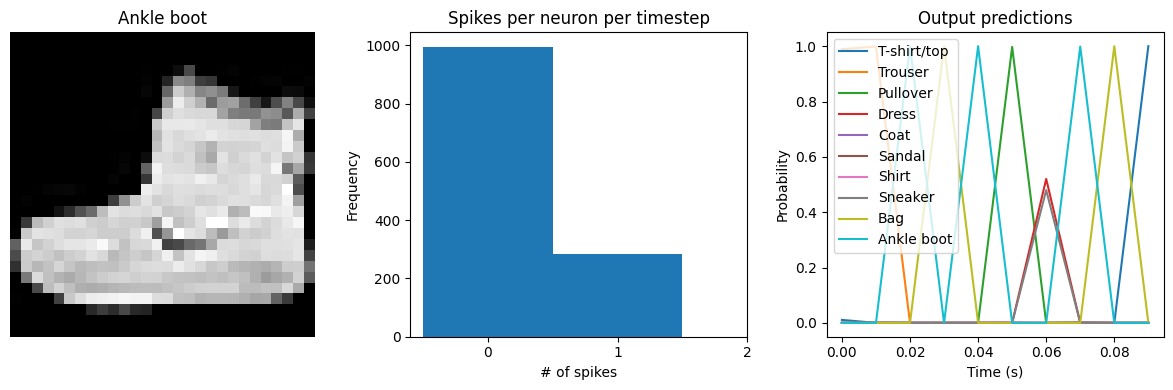

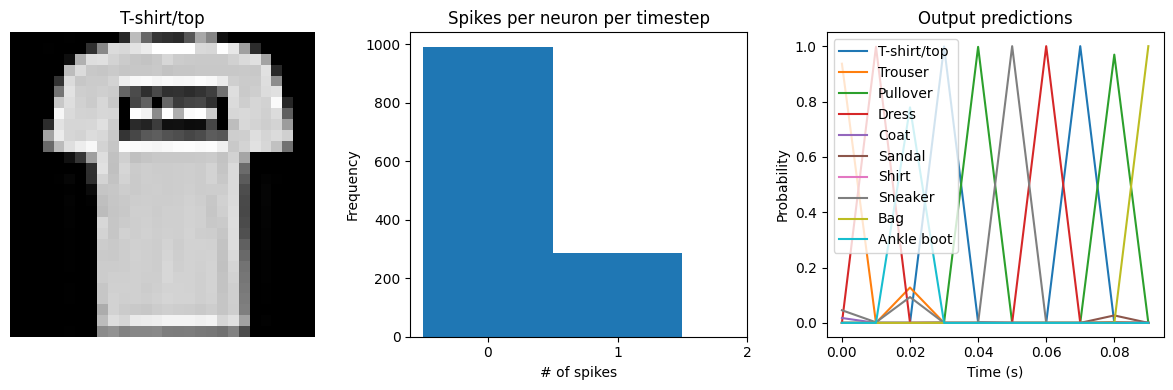

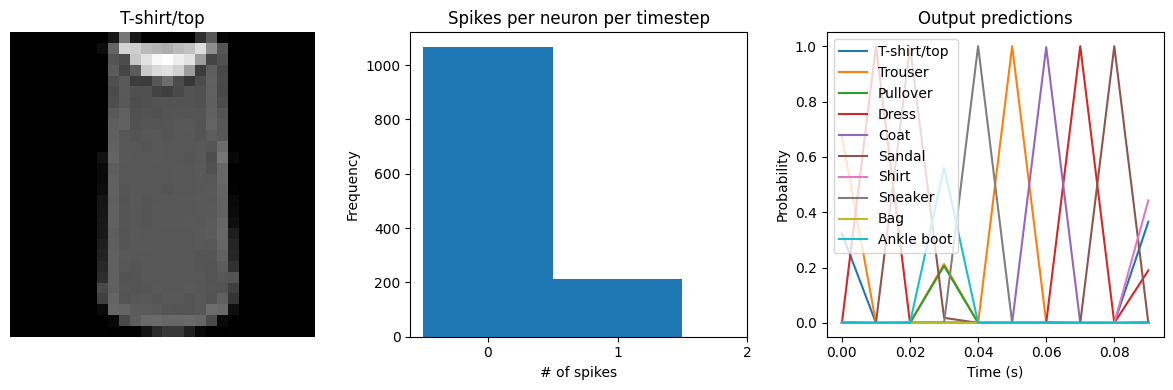

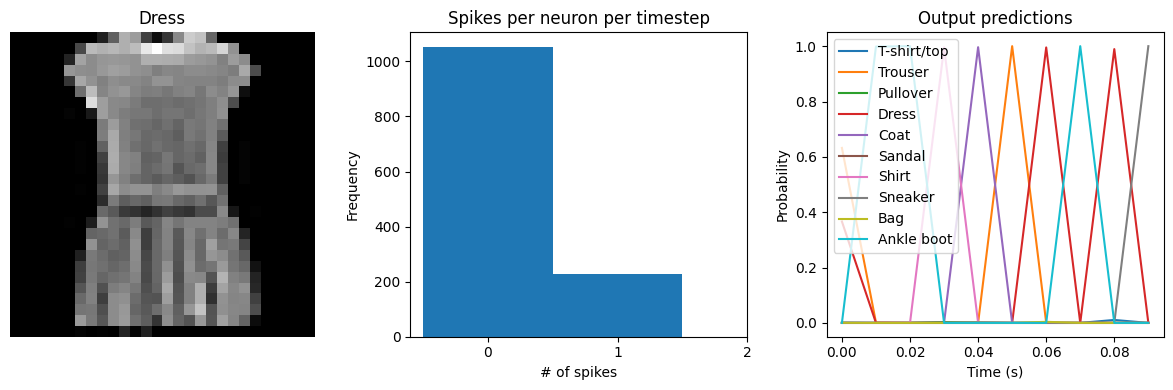

In [ ]:
check_output(regularized_model)

In [ ]:
dt = 0.01

filtered_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    pytorch_spiking.SpikingActivation(
        torch.nn.ReLU(), spiking_aware_training=True, dt=dt
    ),
    # add a lowpass filter on output of spiking layer
    # note: the lowpass dt doesn't necessarily need to be the same as the
    # SpikingActivation dt, but it's probably a good idea to keep them in sync
    # so that if we change dt the relative effect of the lowpass filter is unchanged
    pytorch_spiking.Lowpass(units=128, tau=0.1, dt=dt, return_sequences=False),
    torch.nn.Linear(128, 10),
)

train(filtered_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7176499962806702
Accuracy(Training) (1): 0.7986000180244446
Accuracy(Training) (2): 0.8172666430473328
Accuracy(Training) (3): 0.828000009059906
Accuracy(Training) (4): 0.8357333540916443
Accuracy(Training) (5): 0.8424666523933411
Accuracy(Training) (6): 0.8472166657447815
Accuracy(Training) (7): 0.8509666919708252
Accuracy(Training) (8): 0.8567666411399841
Accuracy(Training) (9): 0.8582666516304016
Training time: 139.68196201324463
Accuracy(Testing) 0.8614166378974915
Testing/Simulation time 144.21281147003174


In [ ]:
check_output(filtered_model)